# **Experiment Notebook**



### Hypothesis
The fine-tuned XGBoost Regressor is expected to outperform the baseline model by achieving lower RMSE and MAPE and higher R², demonstrating improved accuracy and predictive power for the target variable.

In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [3]:
# Import custom package
!pip install my_krml_25552249==2025.0.7.1

  Using cached my_krml_25552249-2025.0.7.1-py3-none-any.whl.metadata (3.0 kB)
Using cached my_krml_25552249-2025.0.7.1-py3-none-any.whl (11 kB)
  Attempting uninstall: my_krml_25552249
    Found existing installation: my_krml_25552249 2025.0.7.0
    Uninstalling my_krml_25552249-2025.0.7.0:
      Successfully uninstalled my_krml_25552249-2025.0.7.0


In [198]:
# Core Libraries
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Statistics & Time Series
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning - Feature Selection
from sklearn.feature_selection import (
    mutual_info_regression,
    mutual_info_classif,
    RFE
)
from sklearn.ensemble import RandomForestRegressor

# Machine Learning - Model Selection & Metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Models
import xgboost as xgb

# Hyperparameter Optimisation
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Custom Modules
from my_krml_25552249.features.selection import (
    plot_corr_matrix,
    run_rfe,
    get_feature_importance,
    correlation_filter,
    vif_filter
)

# Joblib Save/Load
from joblib import dump


---
## A. Project Description


In [5]:
# <Student to fill this section>
student_name = "Shawya Saito"
student_id = "25552249"

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [7]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [8]:
# <Student to fill this section>
business_use_case_description = """
The goal of this project is to predict the total precipitation over the next three days. Accurate short-term rainfall 
forecasts enable businesses in agriculture, logistics, and construction to plan operations effectively, reduce risks, 
and optimise resource allocation based on expected weather conditions."""

In [9]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [10]:
# <Student to fill this section>
business_objectives = """
Accurate predictions of the next three days precipitation allow stakeholders to make better decision making, 
optimising operations and minimising disruptions. Incorrect predictions can have varying impacts: underestimating
rainfall (false negatives) may lead to operational hazards, crop damage, or logistical delays, while overestimating 
rainfall (false positives) can result in unnecessary precautions and resource wastage."""

In [11]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [12]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
The predictions will be used by businesses and organisations that depend on weather conditions, such as agriculture, 
logistics, and construction, to plan activities and allocate resources efficiently. End users include farm managers,
supply chain planners, and project coordinators, while the broader impact extends to employees, customers, and partners
whose operations depend on weather patterns.
"""

In [13]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [14]:
# Load data
df = pd.read_csv("../../data/raw/sydney_weather_2010_2024.csv")

In [15]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          5479 non-null   object 
 1   weather_code                  5479 non-null   float64
 2   temperature_2m_mean           5479 non-null   float64
 3   temperature_2m_max            5479 non-null   float64
 4   temperature_2m_min            5479 non-null   float64
 5   apparent_temperature_mean     5479 non-null   float64
 6   apparent_temperature_max      5479 non-null   float64
 7   apparent_temperature_min      5479 non-null   float64
 8   precipitation_sum             5479 non-null   float64
 9   rain_sum                      5479 non-null   float64
 10  snowfall_sum                  5479 non-null   float64
 11  precipitation_hours           5479 non-null   float64
 12  wind_speed_10m_max            5479 non-null   float64
 13  win

Change date as a date datatype

In [16]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
display(df.head(), df.tail())

,date,weather_code,temperature_2m_mean,temperature_2m_max,temperature_2m_min,apparent_temperature_mean,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,...,surface_pressure_max,surface_pressure_min,winddirection_10m_dominant,wind_gusts_10m_mean,wind_speed_10m_mean,wind_gusts_10m_min,wind_speed_10m_min,wet_bulb_temperature_2m_mean,wet_bulb_temperature_2m_max,wet_bulb_temperature_2m_min
0,2009-12-31 14:00:00+00:00,53.0,22.964250,25.670502,21.070500,25.151611,26.715890,24.240880,3.9,3.9,...,1008.16705,1003.63450,331.647500,21.330000,10.419551,7.200000,4.072935,20.643309,21.304327,19.931772
1,2010-01-01 14:00:00+00:00,63.0,23.612165,26.920502,20.970500,26.942467,32.614998,22.179842,8.6,8.6,...,1005.03217,998.06805,298.610300,26.010002,8.355687,15.119999,1.297998,21.520597,23.316803,19.692732
2,2010-01-02 14:00:00+00:00,51.0,19.882996,20.620499,19.470500,19.709002,21.280840,19.180962,1.1,1.1,...,1013.45440,1005.12430,146.744640,28.275000,12.964748,12.959999,6.915374,16.673801,19.032654,15.879213
3,2010-01-03 14:00:00+00:00,51.0,20.887167,22.520500,19.220500,21.016272,22.343325,19.466248,0.6,0.6,...,1014.66760,1011.22390,69.884770,23.565000,11.067534,11.159999,5.623380,17.092829,17.960950,15.985977
4,2010-01-04 14:00:00+00:00,3.0,22.520498,26.020500,18.620499,24.393919,30.018890,19.811030,0.0,0.0,...,1012.26750,1007.10223,35.137077,24.285002,9.724721,10.080000,4.334974,19.079020,21.130150,16.724476


,date,weather_code,temperature_2m_mean,temperature_2m_max,temperature_2m_min,apparent_temperature_mean,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,...,surface_pressure_max,surface_pressure_min,winddirection_10m_dominant,wind_gusts_10m_mean,wind_speed_10m_mean,wind_gusts_10m_min,wind_speed_10m_min,wet_bulb_temperature_2m_mean,wet_bulb_temperature_2m_max,wet_bulb_temperature_2m_min
5474,2024-12-26 14:00:00+00:00,53.0,26.202085,35.187500,20.887499,26.242342,37.215233,20.495504,0.8,0.8,...,1001.35250,994.86365,339.781250,41.295000,16.679815,22.68,8.211235,19.730782,22.680115,17.356268
5475,2024-12-27 14:00:00+00:00,51.0,21.352081,24.037500,18.587500,21.829940,25.389044,19.079412,0.9,0.9,...,1005.42200,1001.24490,109.408130,31.574997,12.241256,15.48,7.486788,17.523623,18.228878,16.697666
5476,2024-12-28 14:00:00+00:00,1.0,22.214584,27.887499,16.937500,22.691307,28.141224,18.093904,0.0,0.0,...,1012.48310,1004.95560,136.802410,27.345001,10.361734,7.20,3.054701,17.012634,18.846426,15.039368
5477,2024-12-29 14:00:00+00:00,51.0,22.462500,25.587500,19.737500,23.395332,27.735592,20.556278,0.3,0.3,...,1014.50604,1009.16470,84.956360,31.214998,12.572087,19.80,8.936778,18.610620,19.632471,17.276335
5478,2024-12-30 14:00:00+00:00,3.0,22.993752,26.487500,18.737500,24.854470,28.978016,21.394054,0.0,0.0,...,1009.80255,1007.22280,65.856026,25.004995,9.582100,2.88,1.310420,19.490635,20.240698,18.014656


Can observe that 2009-12-31 is included at the start. Since we are only looking at 2010 - 2024, this record will be removed

In [18]:
# removing 2009 record
df = df[df['date'].dt.year != 2009]

Quick check for duplicates and NA values

In [19]:
print(f"Duplicated values:\n{df.duplicated().sum()}")
print(f"All NA counts:\n{df.isna().sum().sum()}")

Duplicated values:
0
All NA counts:
0


### C.2 Define Target variable

Define the target variable by obtaining the sum of the next three days

In [20]:
# Sort by date just in case
df = df.sort_values('date').reset_index(drop=True)

# Regression target: sum of precipitation next 3 days
df['precipitation_sum_next_3_days'] = df['precipitation_sum'].shift(-1) + \
                                  df['precipitation_sum'].shift(-2) + \
                                  df['precipitation_sum'].shift(-3)

Look at summary

In [21]:
df.describe()

,weather_code,temperature_2m_mean,temperature_2m_max,temperature_2m_min,apparent_temperature_mean,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,...,surface_pressure_min,winddirection_10m_dominant,wind_gusts_10m_mean,wind_speed_10m_mean,wind_gusts_10m_min,wind_speed_10m_min,wet_bulb_temperature_2m_mean,wet_bulb_temperature_2m_max,wet_bulb_temperature_2m_min,precipitation_sum_next_3_days
count,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.0,...,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5478.000000,5475.000000
mean,29.699708,17.531641,21.491945,13.918521,16.854930,21.359697,13.013572,2.424608,2.424608,0.0,...,1008.552948,180.629414,25.833206,11.930193,12.108433,5.235005,14.198019,16.151170,12.032783,7.272530
std,26.370733,4.203136,4.560701,4.511792,5.831524,6.445562,6.116412,6.730952,6.730952,0.0,...,7.152074,103.361595,8.798802,4.589165,6.513607,3.625155,4.271426,4.055297,4.662860,14.806577
min,0.000000,7.439583,9.787499,0.937500,3.497893,6.370839,-2.973838,0.000000,0.000000,0.0,...,980.863100,0.100737,8.579999,3.419965,1.440000,0.000000,3.809179,6.469021,-0.378638,0.000000
25%,3.000000,13.964334,17.887499,10.270500,12.024611,16.221031,7.971886,0.000000,0.000000,0.0,...,1003.737430,82.988071,19.394999,8.544647,7.920000,2.620839,10.710197,12.836336,8.180997,0.100000
50%,51.000000,17.626042,21.329000,13.937500,16.775750,21.031617,12.865790,0.100000,0.100000,0.0,...,1008.594020,182.697625,24.269997,10.986866,10.440001,4.510787,14.193471,16.121676,12.013544,1.800000
75%,53.000000,20.949999,24.520500,17.820500,21.565726,26.024167,18.121816,1.600000,1.600000,0.0,...,1013.497925,272.015013,30.836246,14.487701,14.400000,6.821006,17.752553,19.363373,15.962743,7.500000
max,65.000000,30.516668,41.837500,26.887499,32.557170,45.181960,28.333252,138.400010,138.400010,0.0,...,1029.833500,359.857450,76.215004,37.387234,60.120003,29.620802,24.301146,28.387917,22.752897,203.700007


In [22]:
# <Student to fill this section>
target_definition_explanations = """
The target variable is defined as the total precipitation over the next three days. This definition aligns
with the business objective of enabling short-term planning for weather-sensitive operations. By predicting 
the cumulative rainfall, stakeholders can better anticipate potential impacts on agriculture, logistics, and 
construction and make better decisions as a result of it. """

In [23]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [24]:
# Target variable is the precipitation sum of the next 3 days
target = 'precipitation_sum_next_3_days'

In [25]:
# Split into train and test before exploring data
df_train = df[df["date"].dt.year != 2024]
df_test = df[df["date"].dt.year == 2024]

### C.4 Explore Target variable

As our target variable is based on the prediction of the next 3 days, data without the next 3 days of precipitation sum will have NaN values. These will have to be removed from the dataset.

In [26]:
# Look at the last few rows of the data
df_train[['date', 'precipitation_sum_next_3_days']].tail(5)

,date,precipitation_sum_next_3_days
5108,2023-12-27 14:00:00+00:00,26.4
5109,2023-12-28 14:00:00+00:00,7.3
5110,2023-12-29 14:00:00+00:00,6.6
5111,2023-12-30 14:00:00+00:00,1.4
5112,2023-12-31 14:00:00+00:00,2.9


In [27]:
# Remove the last three rows of the data
df_train = df_train.iloc[:-3].reset_index(drop=True)

In [28]:
# Copy the data for EDA, looking at only the training data
df_clean = df_train.copy()

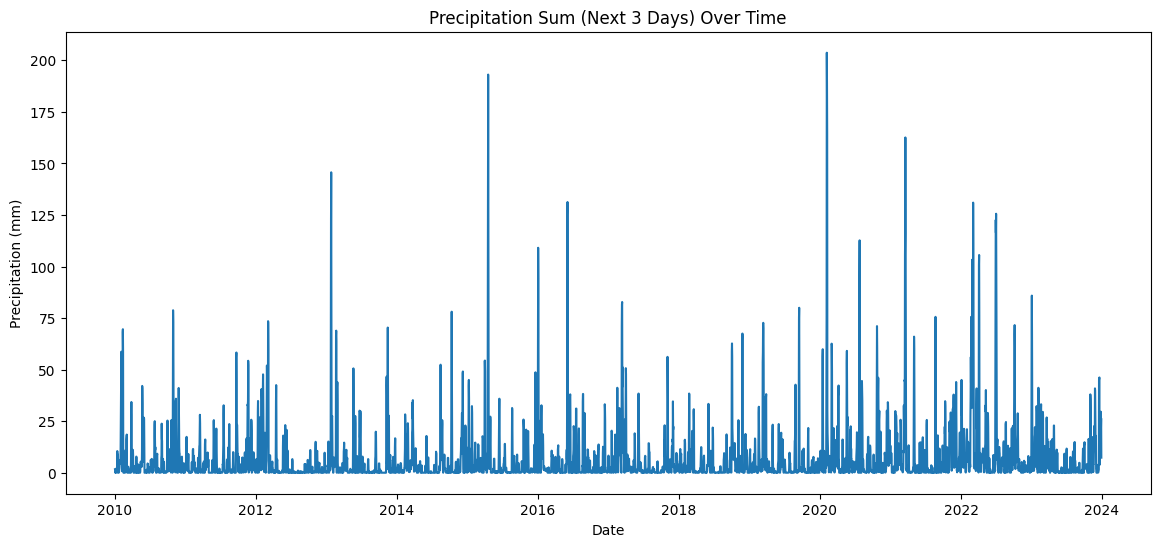

In [29]:
# Precipitation sum next 3 days over time
plt.figure(figsize=(14,6))
sns.lineplot(data=df_clean, x="date", y=target)
plt.title("Precipitation Sum (Next 3 Days) Over Time")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Date")
plt.show()

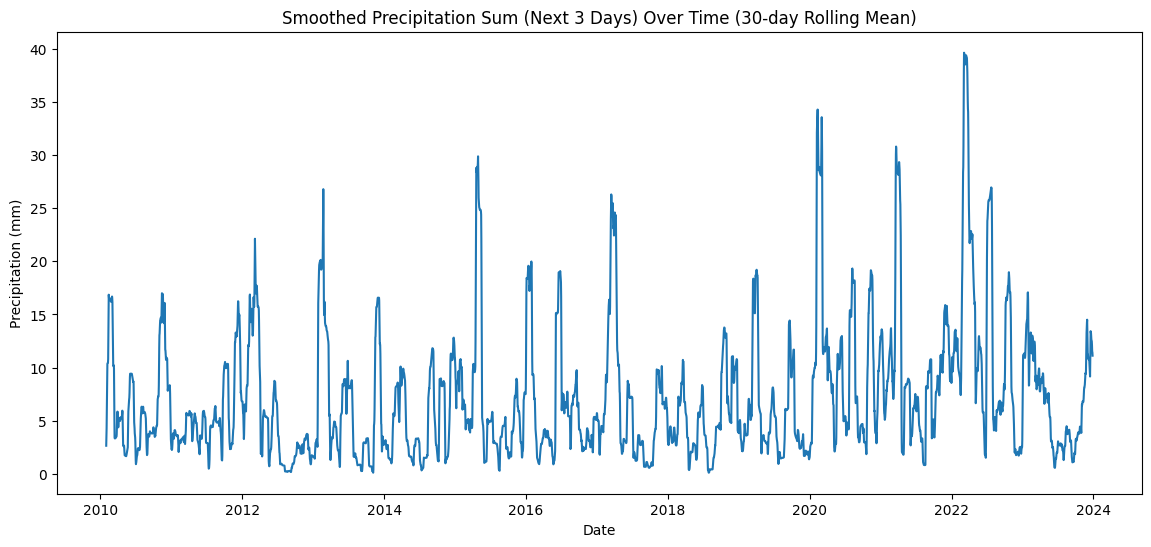

In [30]:
# 30-day rolling average to smooth noise
df_clean["rolling_precip"] = df_clean[target].rolling(window=30).mean()

plt.figure(figsize=(14,6))
sns.lineplot(data=df_clean, x="date", y="rolling_precip")
plt.title("Smoothed Precipitation Sum (Next 3 Days) Over Time (30-day Rolling Mean)")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Date")
plt.show()

df_clean.drop("rolling_precip", axis=1, inplace=True)

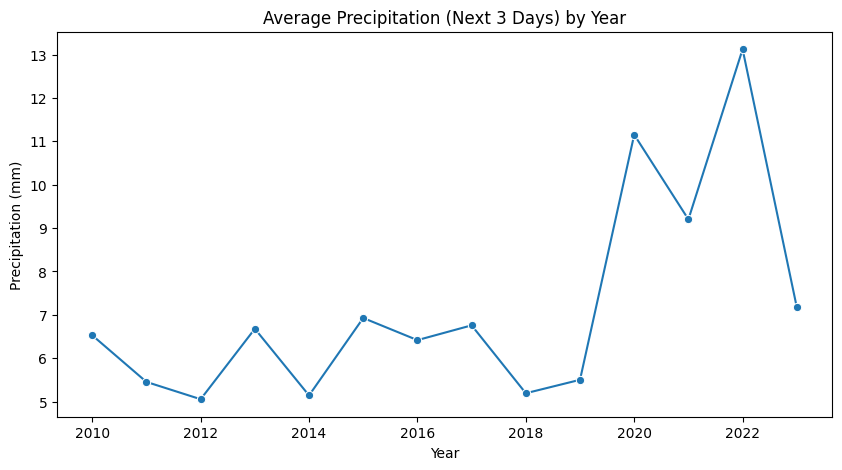

In [31]:
# Extract year and month
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month

plt.figure(figsize=(10,5))
sns.lineplot(
    data=df_clean.groupby("year")[target].mean().reset_index(),
    x="year", y=target, marker="o"
)
plt.title("Average Precipitation (Next 3 Days) by Year")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Year")
plt.show()

Insight: Can see here that the average precipitation increased post 2019, reaching a high ~13mm in 2022.

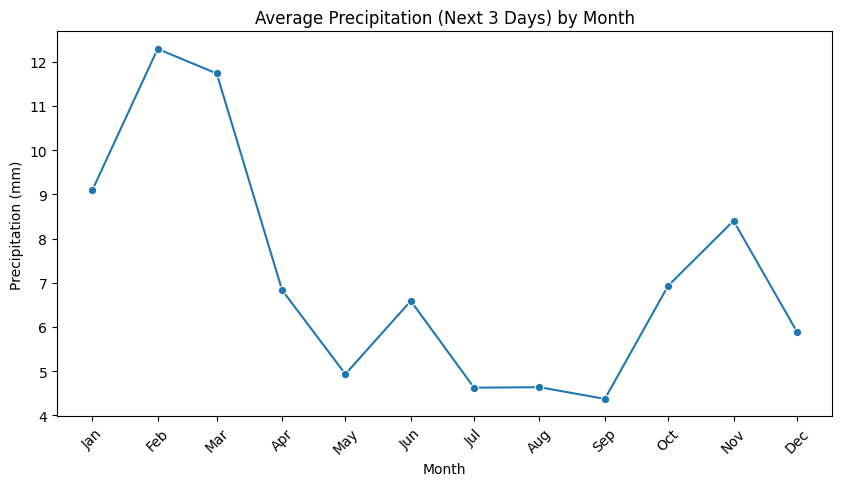

In [32]:
# Look at the average precipitation by month across all years
df_month = df_clean.groupby("month")[target].mean().reset_index()
df_month["date"] = pd.to_datetime(df_month["month"], format="%m")

plt.figure(figsize=(10,5))
sns.lineplot(data=df_month, x="date", y=target, marker="o")

plt.title("Average Precipitation (Next 3 Days) by Month")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Month")

# Format x-axis as month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

Summer / Autumn time seem to be more of the rainier months. Therefore there is some seasonality when it comes to precipitation by month.

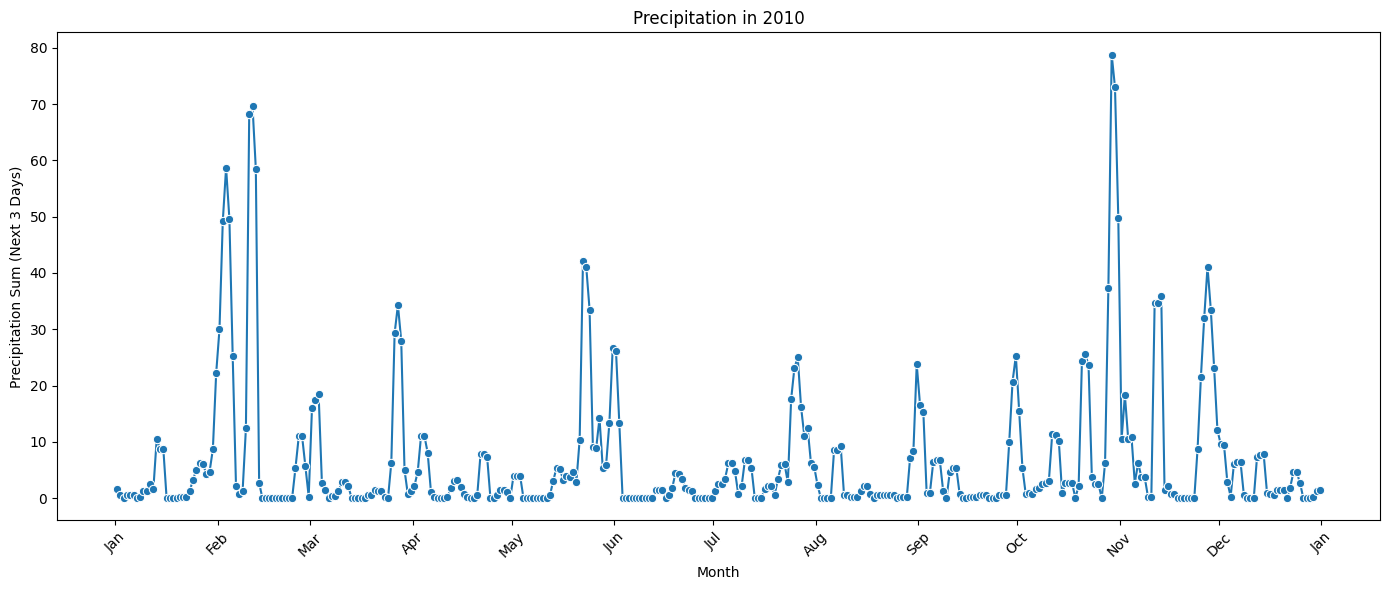

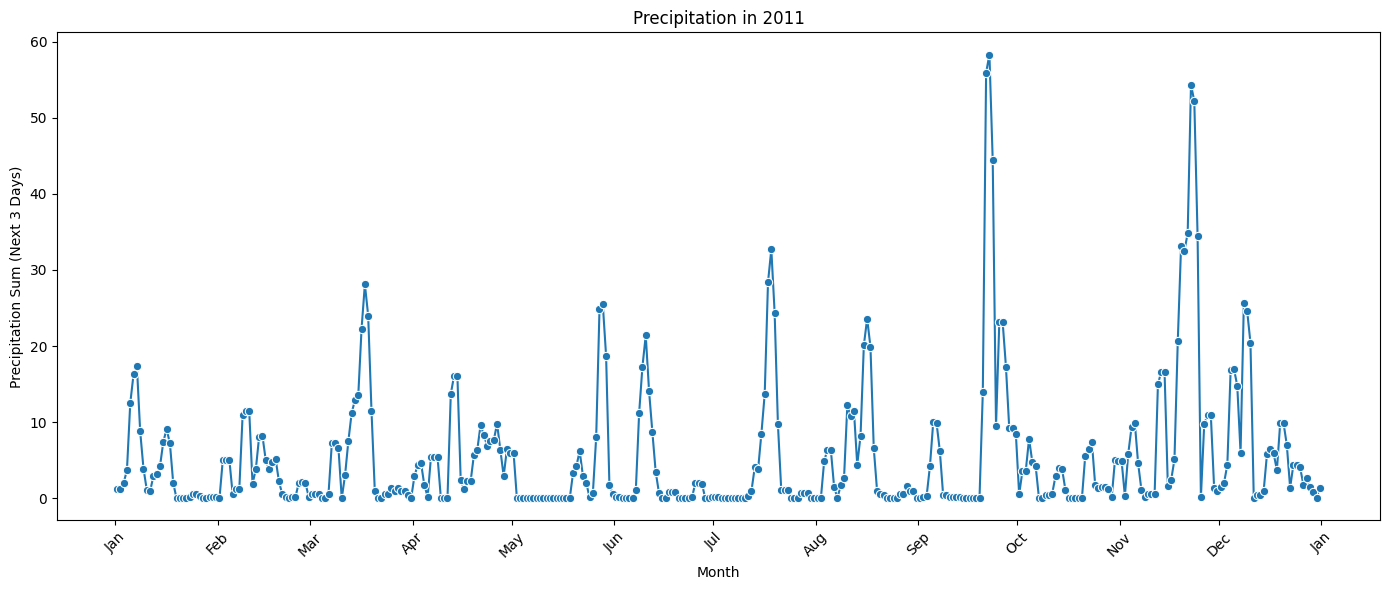

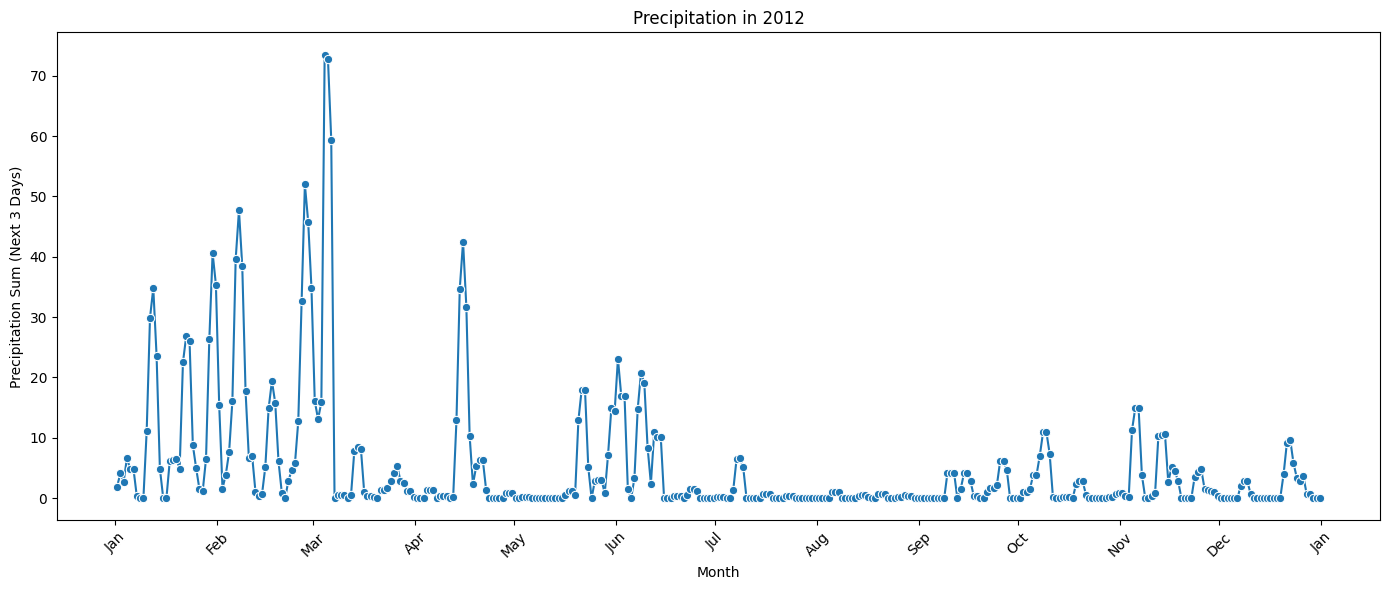

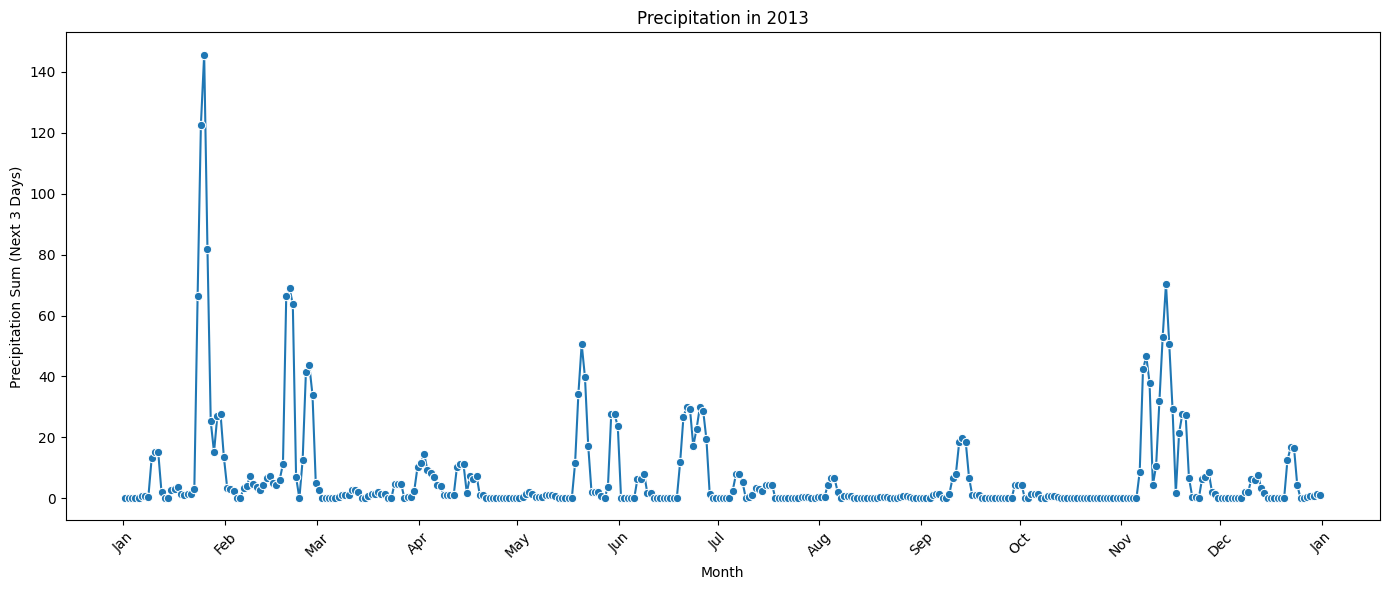

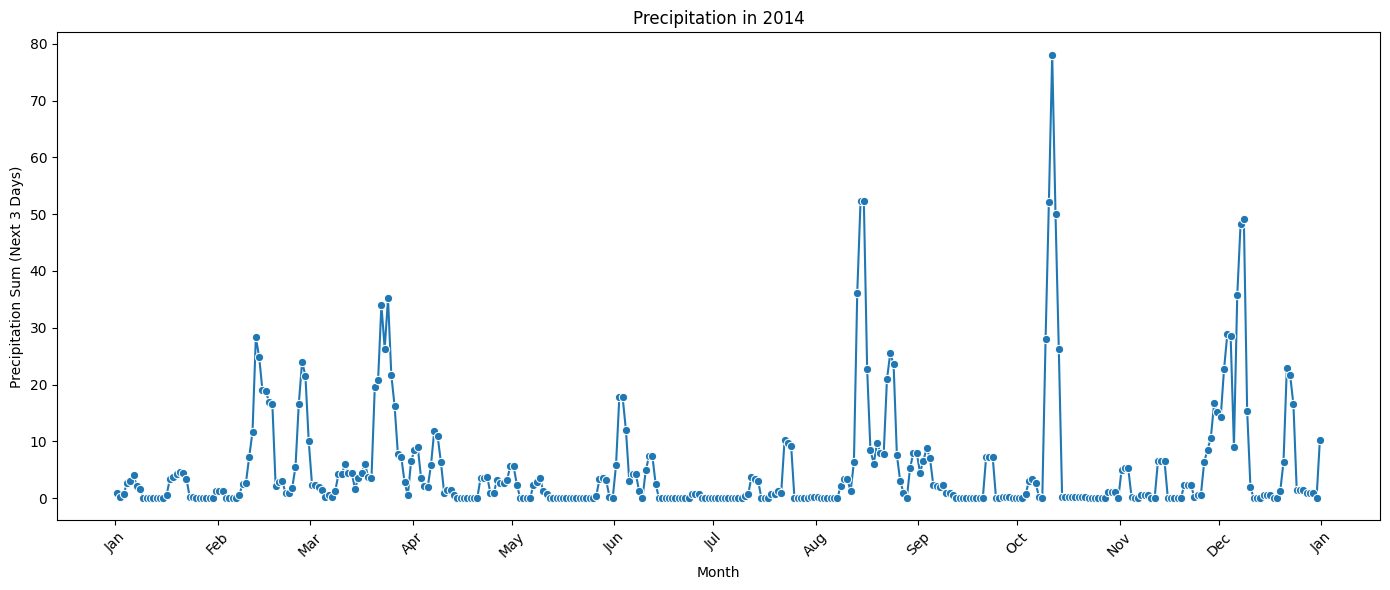

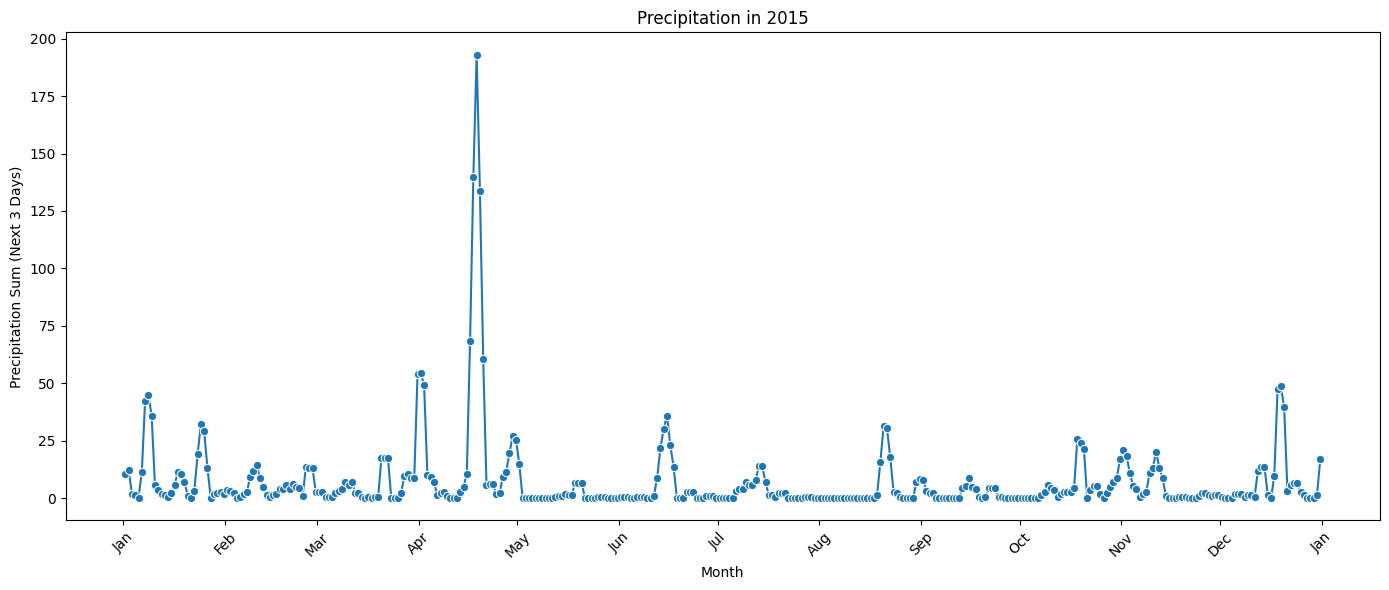

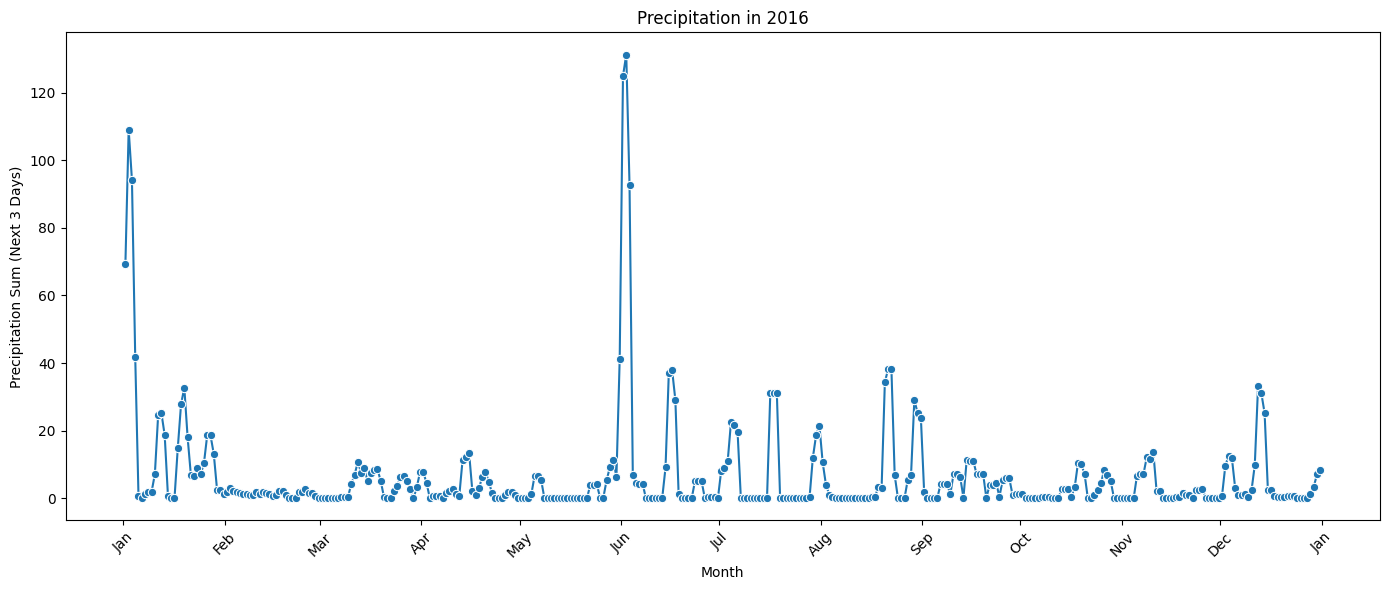

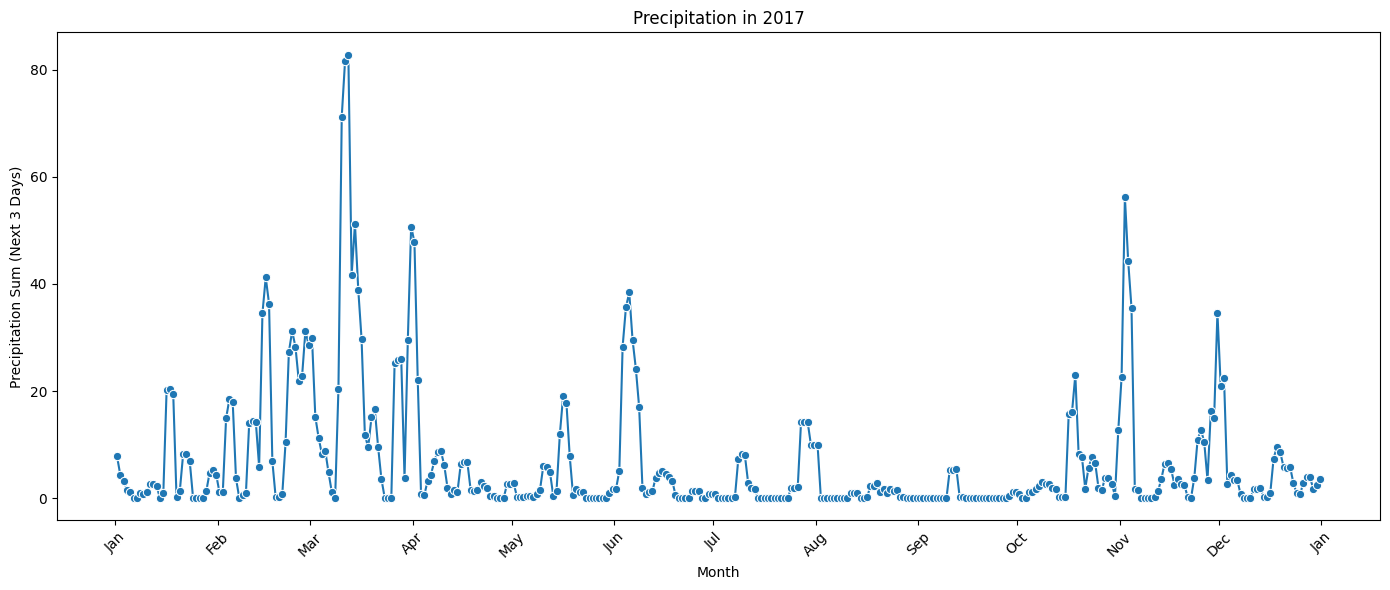

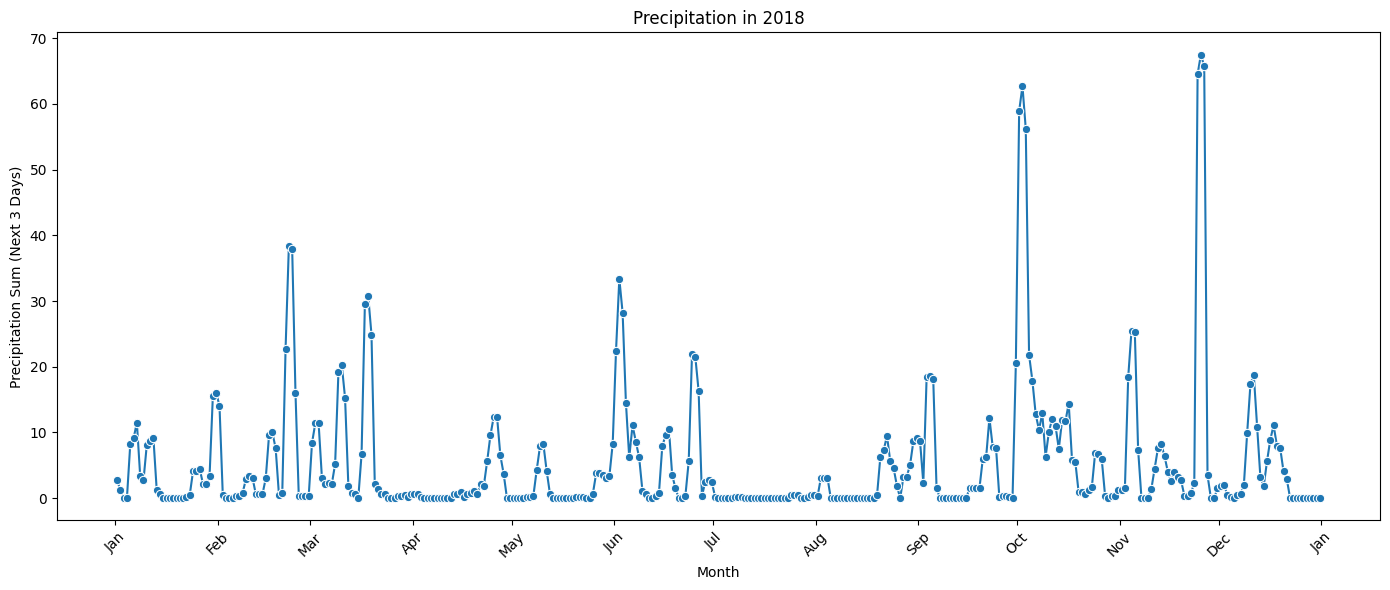

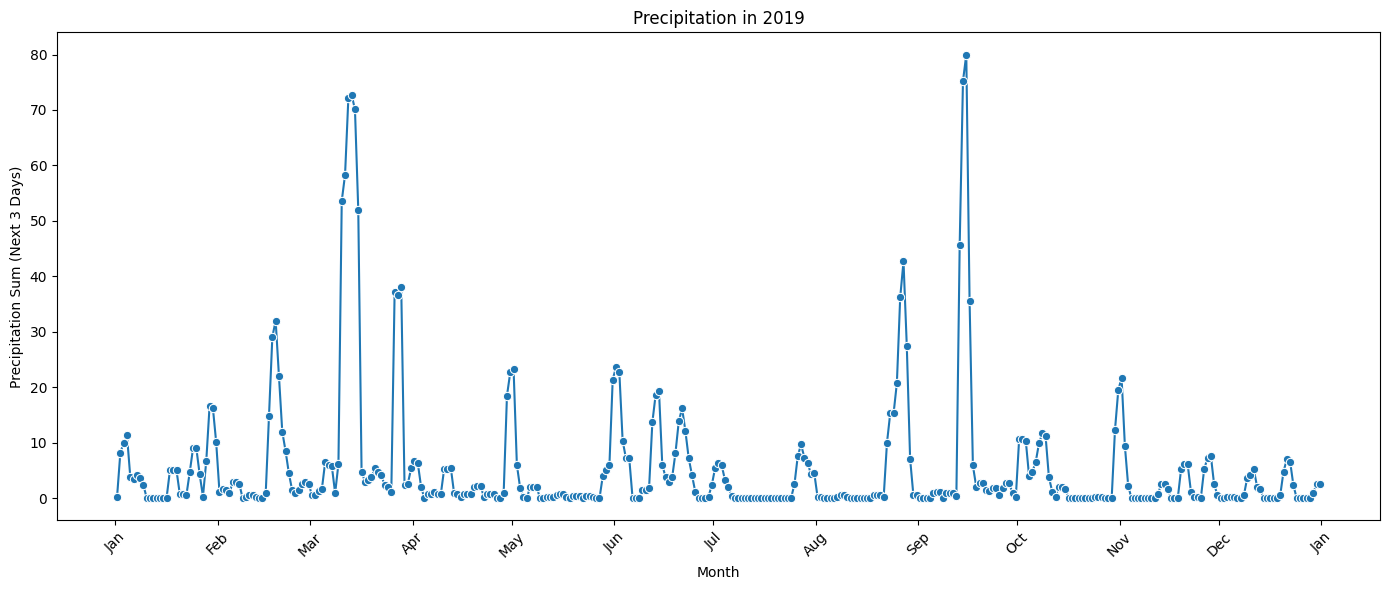

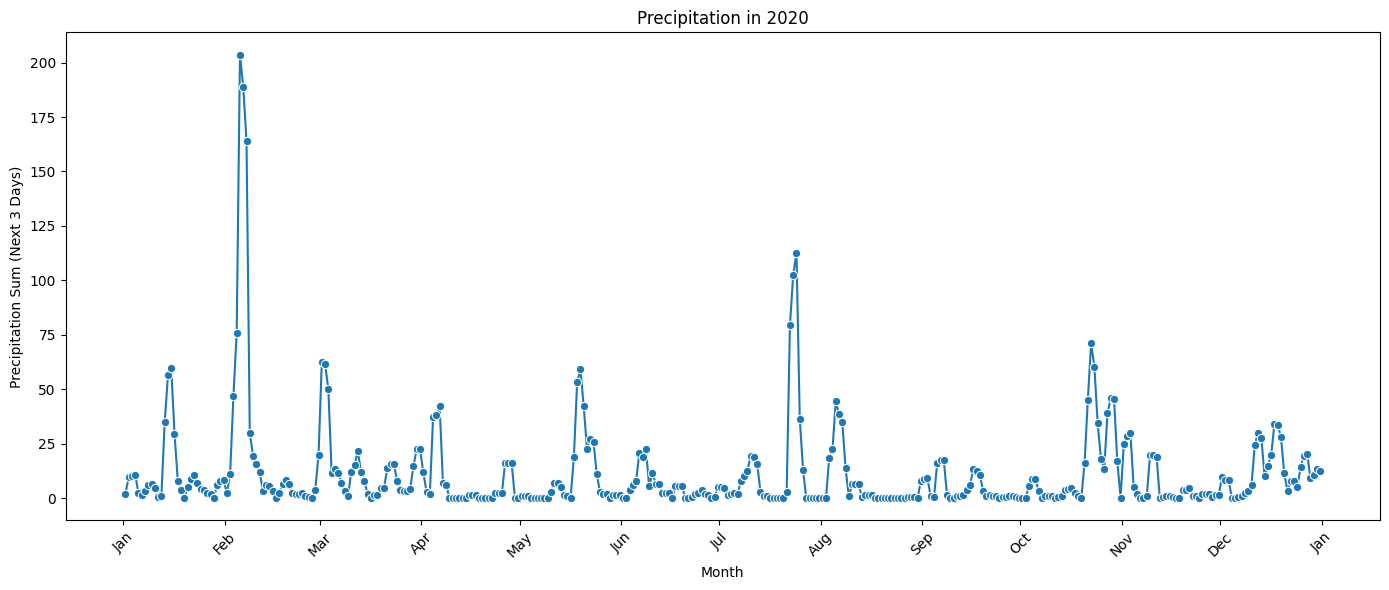

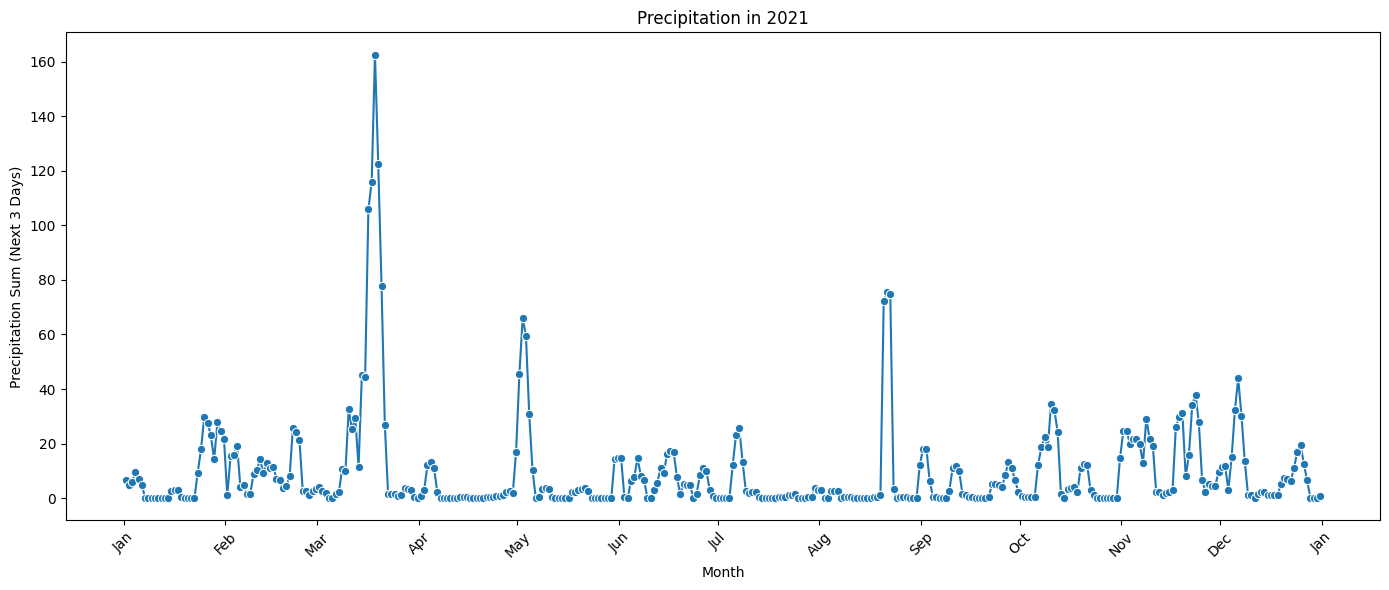

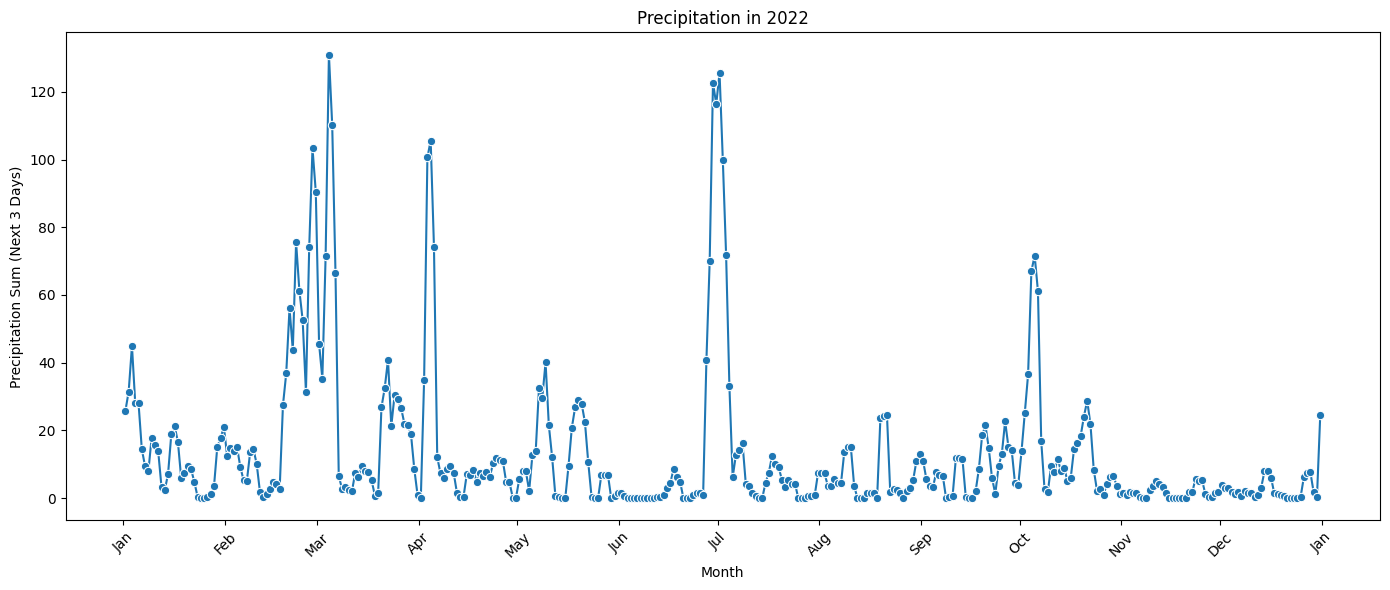

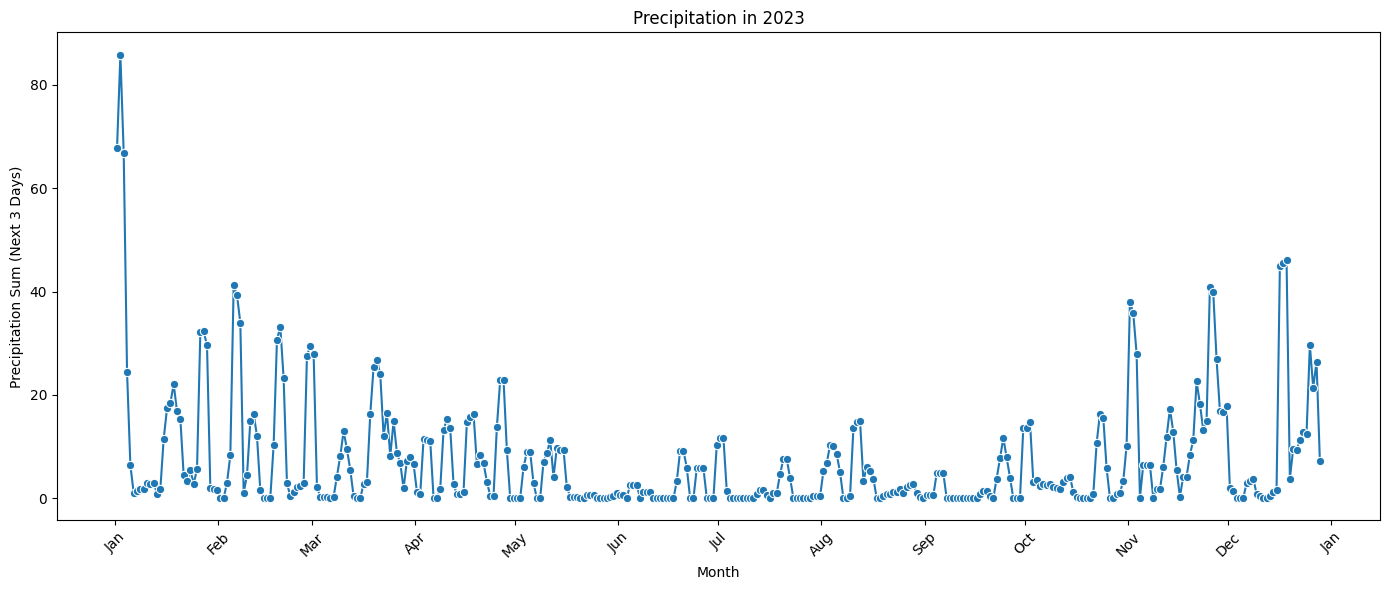

In [33]:
# See the precipitation over the years for any seasonal patterns

# Get all unique years
years = df_clean['date'].dt.year.unique()

# Loop through each year
for year in sorted(df_clean['date'].dt.year.unique()):
    df_year = df_clean[df_clean['date'].dt.year == year]
    
    plt.figure(figsize=(14,6))
    sns.lineplot(data=df_year, x='date', y='precipitation_sum_next_3_days',marker='o')
    
    # Major ticks: months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    plt.title(f'Precipitation in {year}')
    plt.xlabel('Month')
    plt.ylabel('Precipitation Sum (Next 3 Days)')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

typically around Jan - March there will be a date where there is a heavy rain. Also occurs near November to December.

#### Distribution of target

count    5110.000000
mean        7.164247
std        14.809361
min         0.000000
25%         0.100000
50%         1.800000
75%         7.400000
max       203.700007
Name: precipitation_sum_next_3_days, dtype: float64


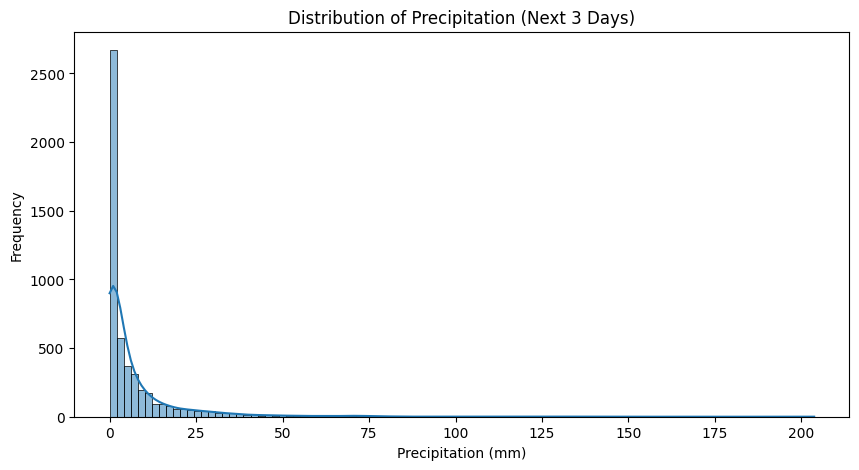

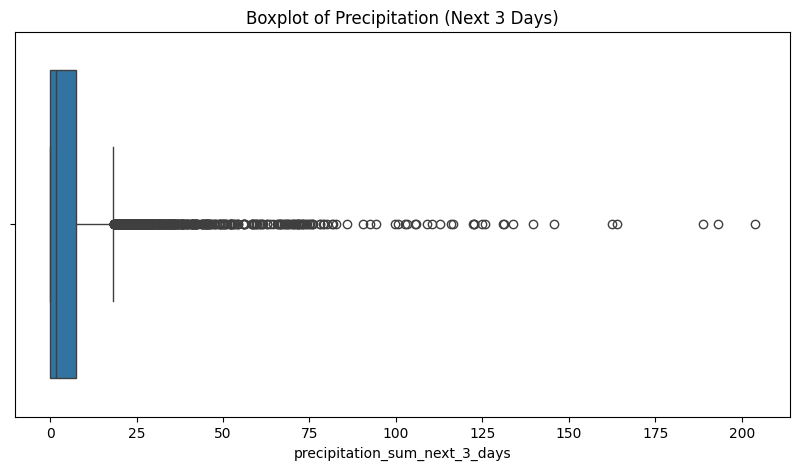

In [34]:
# Summary statistic of target
print(df_clean[target].describe())
# Plot the distribution of target
plt.figure(figsize=(10,5))
sns.histplot(df_clean[target], bins=100, kde=True)
plt.title("Distribution of Precipitation (Next 3 Days)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show

plt.figure(figsize=(10,5))
sns.boxplot(x=df_clean[target])
plt.title("Boxplot of Precipitation (Next 3 Days)")
plt.show()

In [35]:
zero_count = (df_clean[target] == 0).sum()
nonzero_count = (df_clean[target] > 0).sum()
print(f"Zero precipitation days: {zero_count}, Non-zero: {nonzero_count}")


Zero precipitation days: 1123, Non-zero: 3987


In the training data, roughly 1123 have no rain, and 3987 have rained.

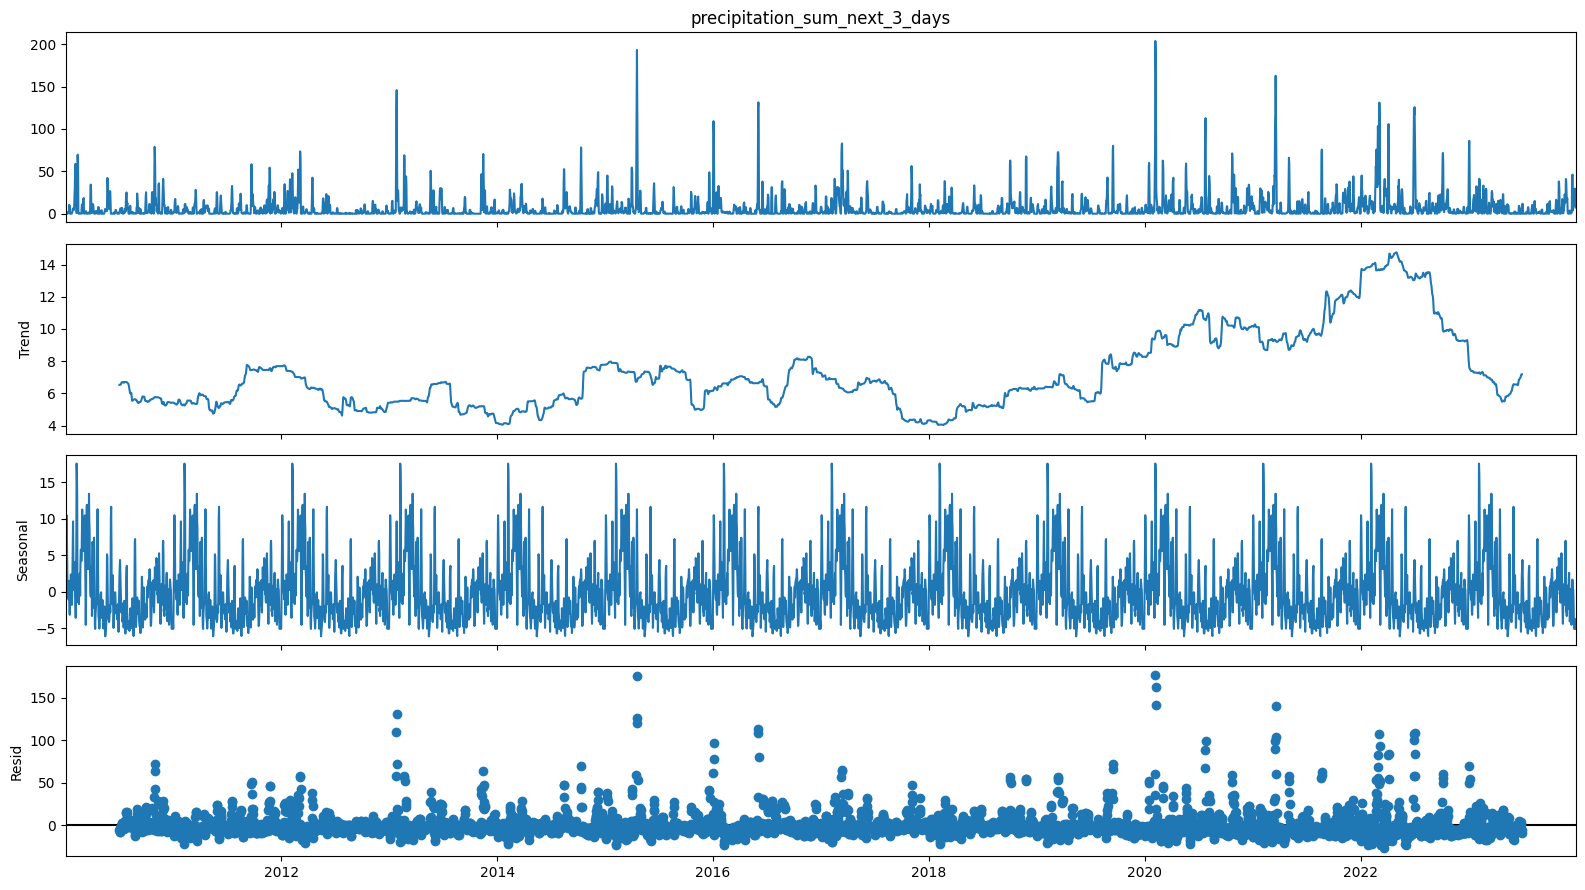

In [36]:
# Seasonal decomposition
decompose_result = seasonal_decompose(df_clean.set_index("date")[target], 
                                      period=365, model='additive')
fig = decompose_result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [37]:
# <Student to fill this section>
target_distribution_explanations = """
The three-day precipitation sum ranges from 0 to 203.7 mm, with a mean of 7.16 mm and a median of 1.8 mm, 
indicating a positively-skewed distribution with many low precipitation days and occasional extreme rainfall events.
The 25th and 75th percentiles are 0.1 mm and 7.4 mm, respectively, further highlighting that most days experience 
relatively low rainfall, while a few days have very high precipitation.

Between 2010 and 2023, there were 1,123 days with no rain and 3,987 days with rainfall. Rainfall also exhibited
seasonal patterns, with higher precipitation typically occurring during Summer and Autumn compared to Winter and Spring.

"""

In [38]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### Below goes through some feature engineering and explores features of interest

### C.5 Explore Feature of Interest `weather_code`

As weather_code is the only categorical column, this feature will be explored

In [39]:
# Look at the unique counts for weather code
df_clean.weather_code.value_counts(ascending=False)

weather_code
3.0     1513
51.0    1255
53.0     510
61.0     373
2.0      356
1.0      315
63.0     291
0.0      283
55.0     174
65.0      40
Name: count, dtype: int64

In [40]:
# Mapping dictionary from code to description
weather_map = {
    0: "Sunny",
    1: "Mainly Sunny",
    2: "Partly Cloudy",
    3: "Cloudy",
    51: "Light Drizzle",
    53: "Drizzle",
    55: "Heavy Drizzle",
    61: "Light Rain",
    63: "Rain",
    65: "Heavy Rain"
}

# Add a new column with descriptions and drop original weather code
df_clean["weather_desc"] = df_clean["weather_code"].map(weather_map)
df_clean = df_clean.drop("weather_code", axis=1)

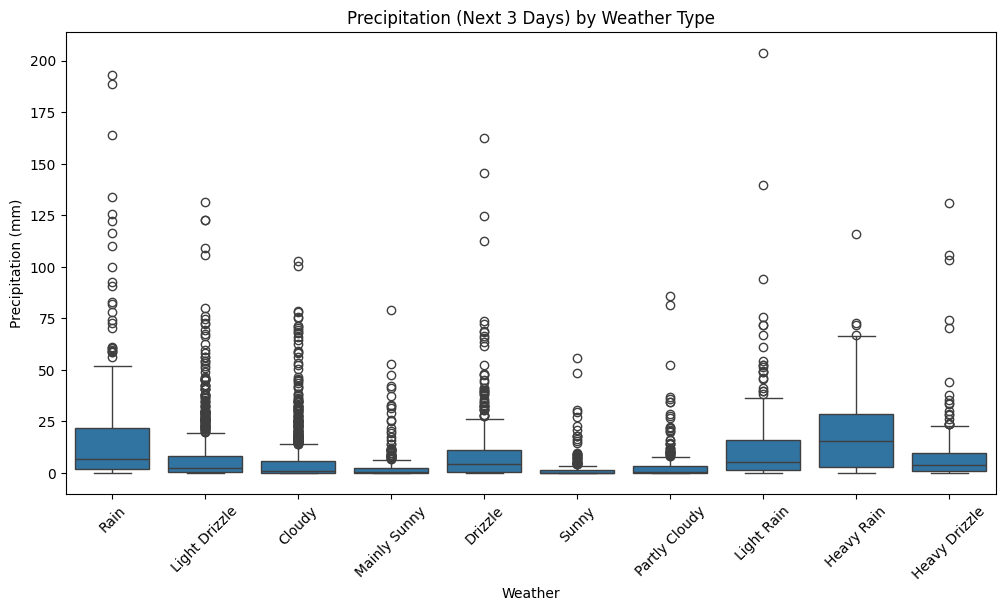

In [41]:
# Relationship with target
plt.figure(figsize=(12,6))
sns.boxplot(x="weather_desc", y="precipitation_sum_next_3_days", data=df_clean)
plt.title("Precipitation (Next 3 Days) by Weather Type")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Weather")
plt.xticks(rotation=45)
plt.show()

weather_desc
Heavy Rain       21.247499
Rain             17.926460
Light Rain       11.857105
Drizzle           9.529412
Heavy Drizzle     9.413793
Light Drizzle     7.100159
Cloudy            5.139788
Mainly Sunny      3.467302
Partly Cloudy     3.461798
Sunny             2.156537
Name: precipitation_sum_next_3_days, dtype: float64


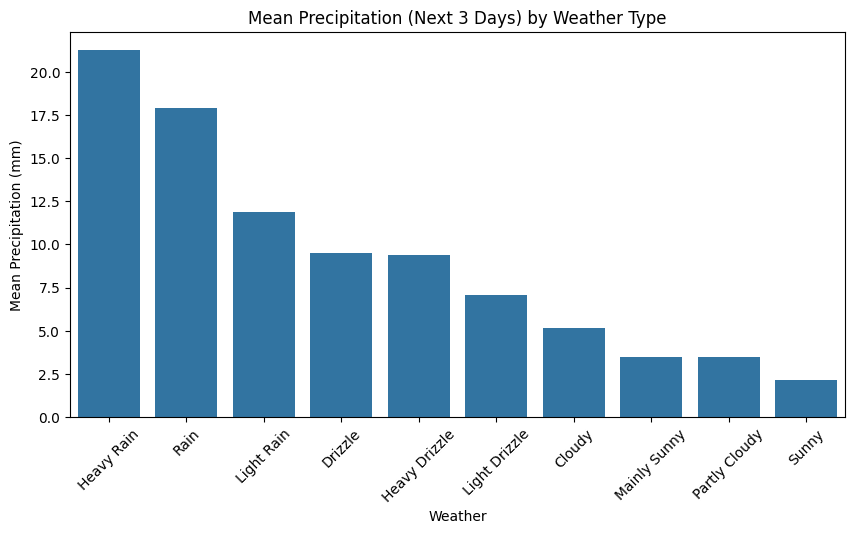

In [42]:
mean_precip = df_clean.groupby("weather_desc")["precipitation_sum_next_3_days"].mean().sort_values(ascending=False)
print(mean_precip)

# Optional: bar plot
plt.figure(figsize=(10,5))
sns.barplot(x=mean_precip.index, y=mean_precip.values)
plt.title("Mean Precipitation (Next 3 Days) by Weather Type")
plt.ylabel("Mean Precipitation (mm)")
plt.xlabel("Weather")
plt.xticks(rotation=45)
plt.show()

In [43]:
# Create list of precipitation arrays for each weather type
groups = [group[target].values for name, group in df_clean.groupby("weather_desc")]

# One-way ANOVA
f_stat, p_val = f_oneway(*groups)
print("F-statistic:", f_stat)
print("p-value:", p_val)


F-statistic: 41.27579024195507
p-value: 8.212129686872995e-72


In [44]:
# <Student to fill this section>
feature_1_insights = """
The mean precipitation over the next three days varies significantly across weather types. Heavier precipitation occurs on days labeled 
as Heavy Rain (21.25 mm), Rain (17.93 mm), and Light Rain (11.86 mm), while lighter or dry conditions, such as Sunny (2.16 mm) or Partly Cloudy 
(3.46 mm), correspond to much lower rainfall. The ANOVA test shows a strong relationship between weather description and precipitation sum 
(F = 41.28, p = 8.21e-72), indicating that the type of weather is a statistically significant predictor of rainfall."""

In [45]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `date`

In [46]:
# Basic time features
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
df_clean['quarter'] = df_clean['date'].dt.quarter

# Add cyclical features

# Encode month as sine/cosine
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['month']/12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['month']/12)

# Encode day of week as sine/cosine
df_clean['dow_sin'] = np.sin(2 * np.pi * df_clean['day_of_week']/7)
df_clean['dow_cos'] = np.cos(2 * np.pi * df_clean['day_of_week']/7)

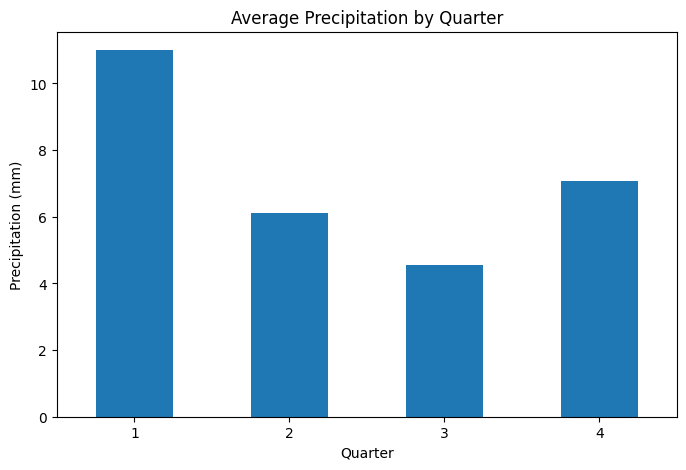

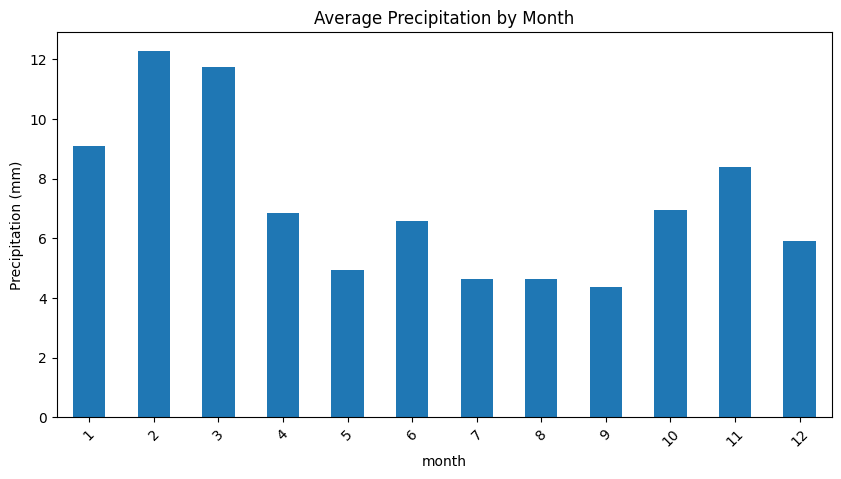

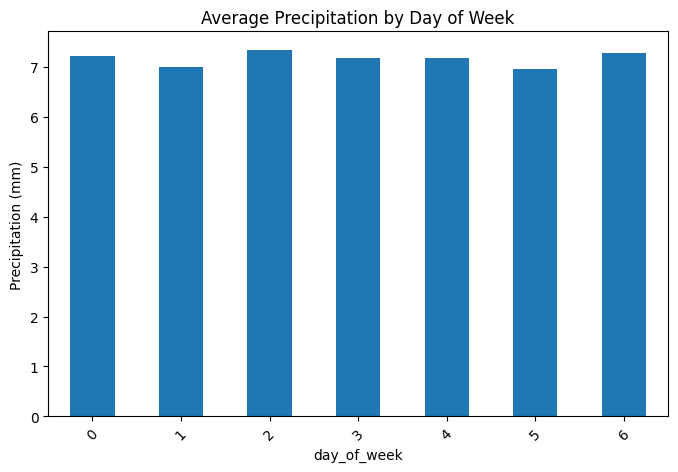

In [47]:
# Average precipitation by quarter
quarter_avg = df_clean.groupby('quarter')['precipitation_sum_next_3_days'].mean()
quarter_avg.plot(kind='bar', figsize=(8,5))
plt.title("Average Precipitation by Quarter")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Quarter")
plt.xticks(rotation=0)  # straight up
plt.show()

# By month
monthly_avg = df_clean.groupby('month')['precipitation_sum_next_3_days'].mean()
monthly_avg.plot(kind='bar', figsize=(10,5))
plt.title("Average Precipitation by Month")
plt.ylabel("Precipitation (mm)")
plt.xticks(rotation=45)
plt.show()

# By day of week
dow_avg = df_clean.groupby('day_of_week')['precipitation_sum_next_3_days'].mean()
dow_avg.plot(kind='bar', figsize=(8,5))
plt.title("Average Precipitation by Day of Week")
plt.ylabel("Precipitation (mm)")
plt.xticks(rotation=45)
plt.show()


In [48]:
# Correlation: Cyclic encoded variables with target
corr_cols = ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
print(df_clean[corr_cols + ['precipitation_sum_next_3_days']].corr()[target])

month_sin                        0.113284
month_cos                        0.079150
dow_sin                          0.002048
dow_cos                         -0.000153
precipitation_sum_next_3_days    1.000000
Name: precipitation_sum_next_3_days, dtype: float64


In [49]:
# Keep only useful time features
# Drop raw month, day_of_week (redundant with sine/cosine)
df_clean = df_clean.drop(columns=['month', 'day_of_week'])

In [50]:
# <Student to fill this section>
feature_2_insights = """
Analysing precipitation by quarter, Q1 has the highest average rainfall, followed by Q4, Q2, and Q3. At the monthly level, 
February and March experience the most rainfall, followed by January and November, while May, July, and August have the 
lowest precipitation. In contrast, precipitation is relatively evenly distributed across the days of the week, showing no 
strong weekday effect. Therefore, similar to previous analysis, there is some seasonal patterns
in terms of rainfall sum. 

Month seem to be a better predictor than day of week, as seen by the correlation values against the target variable.
"""

In [51]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest `lag 1 and lag 2`


In [52]:
# Lag 1 and Lag 2 of precipitation sum
df_clean['precip_sum_lag1'] = df_clean['precipitation_sum'].shift(1)
df_clean['precip_sum_lag2'] = df_clean['precipitation_sum'].shift(2)

# Optional: Drop first 2 rows with NaN after shifting
df_clean = df_clean.dropna(subset=['precip_sum_lag1', 'precip_sum_lag2'])

In [53]:
df_clean[['precipitation_sum_next_3_days', 'precip_sum_lag1', 'precip_sum_lag2']].corr()

,precipitation_sum_next_3_days,precip_sum_lag1,precip_sum_lag2
precipitation_sum_next_3_days,1.000000,0.140834,0.090798
precip_sum_lag1,0.140834,1.000000,0.389248
precip_sum_lag2,0.090798,0.389248,1.000000


In [54]:
# <Student to fill this section>
feature_3_insights = """
The three day precipitation sum has weak correlations with the previous two days (0.14 and 0.09), 
while lag 1 and lag 2 are moderately correlated (0.39), suggesting limited predictive power from 
past precipitation alone."""

In [55]:
# Do not modify this code
print_tile(size="h3", key='feature_3_insights', value=feature_3_insights)

### C.7 Explore Feature of Interest `sunrise and sunset`


In [56]:
print(df_clean['sunrise'].value_counts())
print(df_clean['sunset'].value_counts())

sunrise
1262544609    1
1556569721    1
1557174840    1
1557088394    1
1557001949    1
             ..
1409516033    1
1409429710    1
1409343387    1
1409257063    1
1703789117    1
Name: count, Length: 5108, dtype: int64
sunset
1262596189    1
1556608584    1
1557212984    1
1557126638    1
1557040294    1
             ..
1409557010    1
1409470569    1
1409384128    1
1409297688    1
1703840901    1
Name: count, Length: 5108, dtype: int64


Can see that sunrise and sunset is in a unix timestamp

In [57]:
# Convert Unix timestamp to datetime
df_clean['sunrise_dt'] = pd.to_datetime(df_clean['sunrise'], unit='s')
df_clean['sunset_dt'] = pd.to_datetime(df_clean['sunset'], unit='s')

# Extract hour + minute as decimal
df_clean['sunrise_hour'] = df_clean['sunrise_dt'].dt.hour + df_clean['sunrise_dt'].dt.minute/60
df_clean['sunset_hour'] = df_clean['sunset_dt'].dt.hour + df_clean['sunset_dt'].dt.minute / 60

In [58]:
print(df_clean['sunrise_hour'])
print(df_clean['sunset_hour'])

2       18.833333
3       18.833333
4       18.850000
5       18.866667
6       18.883333
          ...    
5105    18.700000
5106    18.716667
5107    18.716667
5108    18.733333
5109    18.750000
Name: sunrise_hour, Length: 5108, dtype: float64
2       9.150000
3       9.150000
4       9.150000
5       9.150000
6       9.150000
          ...   
5105    9.100000
5106    9.116667
5107    9.116667
5108    9.133333
5109    9.133333
Name: sunset_hour, Length: 5108, dtype: float64


In [59]:
df_clean.drop(columns=['sunrise','sunrise_dt','sunset','sunset_dt'], inplace=True)

In [60]:
# <Student to fill this section>
feature_4_insights = """
Converted sunrise and sunset feature to an appropriate format."""

In [61]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_4_insights)

---
## D. Feature Selection


Here, feature selection techniques will be performed just on the training data to prevent possible data leakage.

In [62]:
# copy df_clean to df_train
df_train = df_clean.copy()

### D.1 Approach "Correlation and Variance Inflation Factor Filtering"


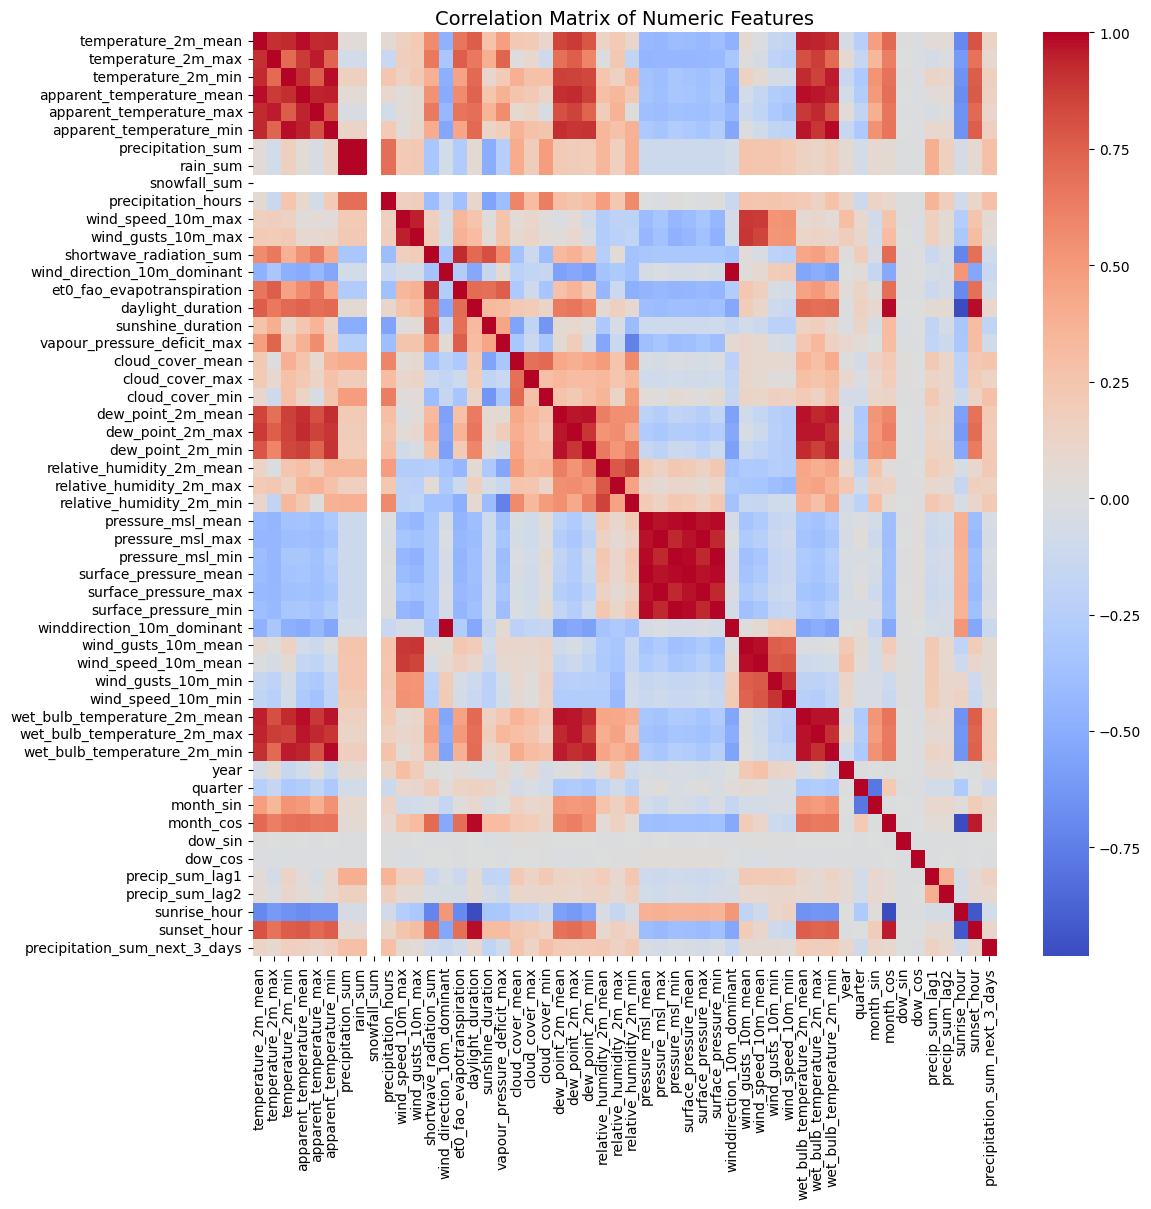

In [63]:
# Plot correlation matrix
plot_corr_matrix(df_train, target="precipitation_sum_next_3_days", annot=False)

Remove snowfall_sum as the values are all 0

In [64]:
# Drop snowfall_sum
df_train.drop('snowfall_sum', axis=1, inplace=True)

**Perform Correlation and VIF Filtering**

In [65]:
# Select numerical columns
numerical_cols = df_train.select_dtypes(include=[np.number]).columns

# Exclude the two target columns
feature_cols = [col for col in numerical_cols if col not in ['precipitation_sum_next_3_days']]

X = df_train.copy()
X = X[feature_cols]

In [66]:
# Correlation filtering
X_corr, dropped_corr = correlation_filter(X, threshold=0.90)
print("Dropped by correlation:", dropped_corr)

print("\n")

# VIF filtering
X_vif, dropped_vif = vif_filter(X_corr, thresh=10.0)
print("Dropped by VIF:", dropped_vif)

[INFO] Correlation filter applied. Dropped 25 features (>|0.9|).
Dropped by correlation: ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'rain_sum', 'wind_gusts_10m_max', 'et0_fao_evapotranspiration', 'dew_point_2m_mean', 'dew_point_2m_max', 'dew_point_2m_min', 'pressure_msl_max', 'pressure_msl_min', 'surface_pressure_mean', 'surface_pressure_max', 'surface_pressure_min', 'winddirection_10m_dominant', 'wind_speed_10m_mean', 'wind_speed_10m_min', 'wet_bulb_temperature_2m_mean', 'wet_bulb_temperature_2m_max', 'wet_bulb_temperature_2m_min', 'month_cos', 'sunrise_hour', 'sunset_hour']


[INFO] Dropping 'year' with VIF=39389.93
[INFO] Dropping 'relative_humidity_2m_mean' with VIF=744.49
[INFO] Dropping 'daylight_duration' with VIF=530.20
[INFO] Dropping 'pressure_msl_mean' with VIF=273.27
[INFO] Dropping 'temperature_2m_mean' with VIF=155.96
[INFO] Dropping 'relative_humidity_2m_max' with VIF=113.15
[INFO] Dro

In [67]:
X_vif.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5108 entries, 2 to 5109
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   precipitation_sum            5108 non-null   float64
 1   precipitation_hours          5108 non-null   float64
 2   shortwave_radiation_sum      5108 non-null   float64
 3   wind_direction_10m_dominant  5108 non-null   float64
 4   vapour_pressure_deficit_max  5108 non-null   float64
 5   cloud_cover_mean             5108 non-null   float64
 6   cloud_cover_min              5108 non-null   float64
 7   wind_gusts_10m_min           5108 non-null   float64
 8   month_sin                    5108 non-null   float64
 9   dow_sin                      5108 non-null   float64
 10  dow_cos                      5108 non-null   float64
 11  precip_sum_lag1              5108 non-null   float64
 12  precip_sum_lag2              5108 non-null   float64
dtypes: float64(13)
memory u

In [68]:
features = [
    'weather_desc',
    'precipitation_sum',
    'precipitation_hours',
    'shortwave_radiation_sum',
    'wind_direction_10m_dominant',
    'vapour_pressure_deficit_max',
    'cloud_cover_mean',
    'cloud_cover_min',
    'wind_gusts_10m_min',
    'month_sin',
    'month_cos',
    'dow_sin',
    'dow_cos',
    'precip_sum_lag1',
    'precip_sum_lag2',
    'precipitation_sum_next_3_days'
]
df_fs = df_train.copy()
df_fs = df_fs[features]

In [69]:
# <Student to fill this section>
feature_selection_1_insights = """
Due to many features being highly correlated, as seen in the correlation plot, a two-step filtering approach was applied.
Correlation analysis first removed redundant features, followed by Variance Inflation Factor (VIF) filtering to address
multicollinearity. This process reduced the feature set while retaining the most informative predictors, improving both 
interpretability and computational efficiency."""

In [70]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "Correlation and mutual info with target variable"


In [71]:
# Select only numeric columns
numeric_features = df_fs.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Compute correlation with target
corr_target = df_fs[numeric_features].corr()[target].sort_values(ascending=False)
print(corr_target)

precipitation_sum_next_3_days    1.000000
cloud_cover_min                  0.285398
precipitation_hours              0.284709
precipitation_sum                0.282949
cloud_cover_mean                 0.261276
precip_sum_lag1                  0.140834
month_sin                        0.113413
precip_sum_lag2                  0.090798
month_cos                        0.079371
wind_gusts_10m_min               0.057789
dow_sin                          0.001885
dow_cos                         -0.000272
vapour_pressure_deficit_max     -0.081855
shortwave_radiation_sum         -0.083857
wind_direction_10m_dominant     -0.124974
Name: precipitation_sum_next_3_days, dtype: float64


In [72]:
X = df_fs.drop(columns=[target])
y = df_fs[target]

# Perform Mutual Information Regression
mi = mutual_info_regression(X.select_dtypes(include=['float','int']), y, random_state=33)
mi_series = pd.Series(mi, index=X.select_dtypes(include=['float','int']).columns)
mi_series.sort_values(ascending=False)

cloud_cover_mean               0.087406
cloud_cover_min                0.081274
month_cos                      0.070390
wind_direction_10m_dominant    0.061213
precipitation_hours            0.057693
precipitation_sum              0.056196
month_sin                      0.039656
precip_sum_lag1                0.033128
shortwave_radiation_sum        0.028446
vapour_pressure_deficit_max    0.023420
wind_gusts_10m_min             0.005046
precip_sum_lag2                0.002671
dow_sin                        0.000000
dow_cos                        0.000000
dtype: float64

In [73]:
# <Student to fill this section>
feature_selection_2_insights = """
Both correlation and mutual information indicate that cloud cover (mean and minimum) and precipitation-related 
features (precipitation hours and sum) are the strongest predictors of the three-day precipitation sum. These 
features show the highest correlation with the target (0.26–0.29) and the largest mutual information values 
(0.067–0.089), suggesting they carry the most informative signal. Lagged precipitation (lag1 and lag2) and seasonal 
indicators (month_sin, month_cos) contribute moderately."""

In [74]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### D.3 Approach "Random Forest Importance and RFE"

In [75]:
# Encode for categorical weather_desc
categorical_cols = ['weather_desc']  
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Perform feature importance using RF_Regressor
feat_imp_rf = get_feature_importance(X_encoded, y, model_type="rf_regressor")
feat_imp_rf

cloud_cover_mean               0.160930
wind_direction_10m_dominant    0.124450
vapour_pressure_deficit_max    0.109742
precipitation_sum              0.082552
shortwave_radiation_sum        0.080025
wind_gusts_10m_min             0.068429
precipitation_hours            0.058724
precip_sum_lag2                0.055029
precip_sum_lag1                0.053378
cloud_cover_min                0.053186
month_sin                      0.036934
dow_sin                        0.036473
dow_cos                        0.025421
month_cos                      0.024515
weather_desc_Light Drizzle     0.006112
weather_desc_Drizzle           0.005714
weather_desc_Light Rain        0.005091
weather_desc_Rain              0.004671
weather_desc_Heavy Drizzle     0.003856
weather_desc_Partly Cloudy     0.001915
weather_desc_Mainly Sunny      0.001269
weather_desc_Heavy Rain        0.001114
weather_desc_Sunny             0.000471
dtype: float64

In [76]:
# Perform RFE with RF_Regressor
selected_rf_cls, rfe_rf_cls = run_rfe(X_encoded, y, model_type="rf_regressor", n_features_to_select=8)
selected_rf_cls

[INFO] Model: rf_regressor | Selected 8 features
Selected features: ['precipitation_sum', 'precipitation_hours', 'shortwave_radiation_sum', 'wind_direction_10m_dominant', 'vapour_pressure_deficit_max', 'cloud_cover_mean', 'wind_gusts_10m_min', 'precip_sum_lag1']


['precipitation_sum',
 'precipitation_hours',
 'shortwave_radiation_sum',
 'wind_direction_10m_dominant',
 'vapour_pressure_deficit_max',
 'cloud_cover_mean',
 'wind_gusts_10m_min',
 'precip_sum_lag1']

In [77]:
# <Student to fill this section>
feature_selection_3_insights = """
Using a Random Forest Regressor, the most important predictors of the three-day precipitation sum are cloud cover, 
wind direction, vapour pressure deficit, shortwave radiation, precipitation sum, precipitation hours, wind gusts, and
lagged precipitation. These features capture both current weather conditions and recent rainfall patterns, aligning with
physical drivers of precipitation. Recursive Feature Elimination with the RF model confirmed the top 8 features: 
precipitation_sum, precipitation_hours, shortwave_radiation_sum, wind_direction_10m_dominant, vapour_pressure_deficit_max,
cloud_cover_mean, wind_gusts_10m_min, and precip_sum_lag2, as the most informative, supporting a focused feature set for model
training while reducing dimensionality and potential noise from less informative variables."""

In [78]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_3_insights', value=feature_selection_3_insights)

## D.z Final Selection of Features

In [79]:
# <Student to fill this section>

features_list = [
    'precipitation_sum',
    'precip_sum_lag1', 
    'precip_sum_lag2', 
    'precipitation_hours',
    'cloud_cover_mean',
    'wind_direction_10m_dominant',
    'vapour_pressure_deficit_max',
    'shortwave_radiation_sum',
    'wind_gusts_10m_min'
]
target = ['precipitation_sum_next_3_days']


In [80]:
# <Student to fill this section>
feature_selection_explanations = """
The features selected focus on current and recent weather conditions that directly influence
precipitation: total and lagged precipitation, precipitation hours, cloud cover, wind direction
and gusts, shortwave radiation, and vapour pressure deficit. While seasonal indicators (month_sin, month_cos)
show some correlation with rainfall, they were not included because the model captures most of the predictive 
signal through the direct weather measurements (as observed in RFE and Importance), making seasonal features redundant and reducing potential noise."""

In [81]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

Apply all previously created and transformed features to the entire dataset df before splitting into df_train and df_test. This is necessary because some features, such as precip_sum_lag1 and precip_sum_lag2, depend on previous records. If the dataset were split first, the beginning of the test set would be missing these lag values.

In [82]:
# Load all the data again
df = pd.read_csv("../../data/raw/sydney_weather_2010_2024.csv")

# Remove the single 2009 record
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year != 2009]

## Create the target variable
df = df.sort_values('date').reset_index(drop=True)

# Regression target: sum of precipitation next 3 days
df['precipitation_sum_next_3_days'] = df['precipitation_sum'].shift(-1) + \
                                  df['precipitation_sum'].shift(-2) + \
                                  df['precipitation_sum'].shift(-3)
# Remove the last three rows of the data
df = df.iloc[:-3].reset_index(drop=True)

## Mapping weather_description
# Mapping dictionary from code to description
weather_map = {
    0: "Sunny",
    1: "Mainly Sunny",
    2: "Partly Cloudy",
    3: "Cloudy",
    51: "Light Drizzle",
    53: "Drizzle",
    55: "Heavy Drizzle",
    61: "Light Rain",
    63: "Rain",
    65: "Heavy Rain"
}

# Add a new column with descriptions and drop original weather code
df["weather_desc"] = df["weather_code"].map(weather_map)
df = df.drop("weather_code", axis=1)


## Creating lag features
# Create lag features
df['precip_sum_lag1'] = df['precipitation_sum'].shift(1)
df['precip_sum_lag2'] = df['precipitation_sum'].shift(2)

# Drop the first two rows with NaN in lag features
df = df.dropna(subset=['precip_sum_lag1', 'precip_sum_lag2']).reset_index(drop=True)


## Time features
# Basic time features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter

# Add cyclical features

# Encode month as sine/cosine
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

# Encode day of week as sine/cosine
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# Convert Unix timestamp to datetime
df['sunrise_dt'] = pd.to_datetime(df['sunrise'], unit='s')
df['sunset_dt'] = pd.to_datetime(df['sunset'], unit='s')

# Extract hour + minute as decimal
df['sunrise_hour'] = df['sunrise_dt'].dt.hour + df['sunrise_dt'].dt.minute/60
df['sunset_hour'] = df['sunset_dt'].dt.hour + df['sunset_dt'].dt.minute / 60

df.drop(columns=['snowfall_sum','sunrise', 'sunrise_dt', 'sunset', 'sunset_dt', 'day_of_week', 'month'], inplace=True)

### E.1 Data Transformation <put_name_here>

In [83]:
# <Student to fill this section>
data_cleaning_1_explanations = """
No additional data transformation or scaling is required because the XGBoost Regressor is a tree-based model that is inherently insensitive to feature scaling. Fixing scaling issues is therefore unnecessary."""

In [84]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

---
## F. Feature Engineering

In [85]:
# <Student to fill this section>
feature_engineering_2_explanations = """
Feature engineering has already been performed prior to feature selection to create informative 
variables that capture relevant weather patterns and temporal dependencies. These engineered features
improve model predictive power, reduce noise from raw data, and ensure that the most relevant signals
are available for training and evaluation."""

In [86]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

Here, we will prepare to save X_data, y_data, X_test and y_test with all potential variables for future experiments.

In [87]:
# Split into train and test
df_train = df[df["date"].dt.year != 2024]
df_test = df[df["date"].dt.year == 2024]

In [88]:
# Split features and target for train
X_data = df_train.drop(columns=target, axis=1)
y_data = df_train[target] 

# Split features and target for test
X_test = df_test.drop(columns=target, axis=1)
y_test = df_test[target]

In [89]:
# <Student to fill this section>
data_splitting_explanations = """
The dataset includes all years for the three-day precipitation sum, with training data spanning 2010–2023 
and testing data from 2024 to ensure evaluation on unseen future data. For model development and hyperparameter
tuning, the training set is further split using TimeSeriesSplit, which preserves temporal order and prevents data
leakage by ensuring that each validation fold occurs after its corresponding training fold."""

In [90]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

---
## H. Save Datasets

> Do not change this code

In [91]:
# # Do not modify this code
# # Save training set
# try:
#   X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
#   y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

#   X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
#   y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

#   X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
#   y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
# except Exception as e:
#   print(e)

In [92]:
# Do not modify this code
# Save training set
try:
  X_data.to_csv('../../data/processed/X_data_reg.csv', index=False)
  y_data.to_csv('../../data/processed/y_data_reg.csv', index=False)

  X_test.to_csv('../../data/processed/X_test_reg.csv', index=False)
  y_test.to_csv('../../data/processed/y_test_reg.csv', index=False)
except Exception as e:
  print(e)

In [93]:
# Load X_data with the selected features
X_data = df_train[features_list]
y_data = df_train[target]

X_test = df_test[features_list]
y_test = df_test[target]

---
## I. Selection of Performance Metrics


In [182]:
# <Student to fill this section>
performance_metrics_explanations = """
The primary metric for evaluating the model is RMSE, as it captures the average magnitude of prediction errors
and is sensitive to large deviations in precipitation. Additional metrics, including MAE, and R^2, are 
also considered to provide complementary perspectives. MAE reflects average absolute errors and R^2 indicates how well the model explains variance in the target. Together, 
these metrics give a comprehensive assessment of model performance."""

In [183]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm



In [184]:
# <Student to fill this section>
algorithm_selection_explanations = """
The XGBoost Regressor is suited for this problem because it is a tree based ensemble method that can handle non-linear relationships, 
interactions between features, and outliers effectively. It also requires minimal data preprocessing, is robust to multicollinearity, 
\and provides feature importance insights, making it ideal for predicting the three day precipitation sum from multiple correlated weather variables."""

In [185]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters


During hyperparameter tuning, the training data is split using TimeSeriesSplit to ensure that each validation set occurs after the corresponding training set. This allows the model to be evaluated on multiple sequential folds for hyperparameter selection before testing on unseen future data.

In [131]:
# Define 5-fold time-series cross-validation strategy to preserve temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Define hyperparameter search space for XGBoost using Hyperopt
space = {
    'max_depth': hp.choice('max_depth', range(2, 10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.choice('n_estimators', range(50, 500)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

In [172]:
# Objective function for Hyperopt: trains XGBoost using time-series CV and returns mean RMSE as loss
def objective(params):
    # List to store metrics for each fold
    rmses = []
    maes = []
    pct_errors = []

    # Time-series cross-validation loop
    for train_idx, val_idx in tscv.split(X_data):
        X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]

        # Initialise Model
        model = xgb.XGBRegressor(
            **params,
            random_state=33,
            objective='reg:squarederror',
            tree_method='hist',
            early_stopping_rounds=20,
            n_jobs=-1,
            deterministic=True
        )

        # Fit model and evaluate on the validation set
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        # Generate predictions
        preds = model.predict(X_val)

        # Store predictions
        rmses.append(mean_squared_error(y_val, preds, squared=False))
        maes.append(mean_absolute_error(y_val, preds))
        
    # Return dictionary for Hyperopt
    return {
        'loss': np.mean(rmses), # maximise RMSE
        'status': STATUS_OK,
        'fold_rmse': rmses,
        'fold_mae': maes,
    }

# Run Hyperopt Optimisation
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(333)
)

100%|██████████████████████████████████████| 50/50 [00:22<00:00,  2.25trial/s, best loss: 14.147997254304153]


In [173]:
# Best hyperparameters
print("Best hyperparameters:", best)

Best hyperparameters: {'colsample_bytree': np.float64(0.9806647745007819), 'learning_rate': np.float64(0.0959164416655911), 'max_depth': np.int64(0), 'n_estimators': np.int64(277), 'subsample': np.float64(0.6070741279750801)}


In [188]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
The selected hyperparameters are tuned because they  impact the XGBoost model’s learning behavior and generalisation:

max_depth: Controls the depth of each tree, deeper trees can capture more complex patterns but risk overfitting.

learning_rate: Determines the step size at each boosting iteration, lower values improve stability but require more trees.

n_estimators: Sets the number of boosting rounds, more trees can improve accuracy but increase computation and overfitting risk.

subsample: Fraction of training samples used per tree, helps prevent overfitting by introducing randomness.

colsample_bytree: Fraction of features used per tree, reduces correlation among trees and improves generalisation.

Using Hyperopt allows efficient exploration of this parameter space to find the combination that minimises validation error and maximizes predictive performance."""

In [189]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [190]:
# Map 'max_depth' choice index back to actual value
max_depth_choices = list(range(2, 10))

final_params = {
    'max_depth': max_depth_choices[int(best['max_depth'])],
    'n_estimators': int(best['n_estimators']),
    'learning_rate': float(best['learning_rate']),
    'subsample': float(best['subsample']),
    'colsample_bytree': float(best['colsample_bytree']),
    'random_state': 33,                                       
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'n_jobs': -1
}

In [191]:
# Instantiate final model
final_model = xgb.XGBRegressor(**final_params)

# Fit on all training data
final_model.fit(X_data, y_data)

# Predict on test set
y_pred = final_model.predict(X_test)

In [194]:
# Save final model
try:
    dump(final_model, '../../models/precipitation_fall/xgb_model_reg.joblib')
except Exception as e:
    print(e)

### J.4 Model Technical Performance

#### Cross Validation Results

In [195]:
# Best trial index
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_trial = trials.trials[best_trial_idx]

# Fold-wise metrics for best hyperparameters
print("Fold-wise RMSE:", best_trial['result']['fold_rmse'])
print("Mean RMSE:", best_trial['result']['loss'])
print("Fold-wise MAE:", best_trial['result']['fold_mae'])
print("Mean MAE:", np.mean(best_trial['result']['fold_mae']))

Fold-wise RMSE: [np.float64(11.051158194037205), np.float64(15.057409775240233), np.float64(11.33135330492085), np.float64(18.03638888625746), np.float64(15.26367611106503)]
Mean RMSE: 14.147997254304153
Fold-wise MAE: [np.float64(5.961863507914324), np.float64(7.000607168295076), np.float64(6.692108721032103), np.float64(8.142283611824839), np.float64(8.46730172933904)]
Mean MAE: 7.2528329476810764


#### Test Set Results

In [200]:
# RMSE
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

# MAE
test_mae = mean_absolute_error(y_test, y_pred)

# R^2
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-squared:", r2)

Test RMSE: 13.978765500468313
Test MAE: 8.177428286038806
Test R-squared: 0.10010665655136108


#### Test Set Results Visualisations

Predicted vs Actual Scatter plot

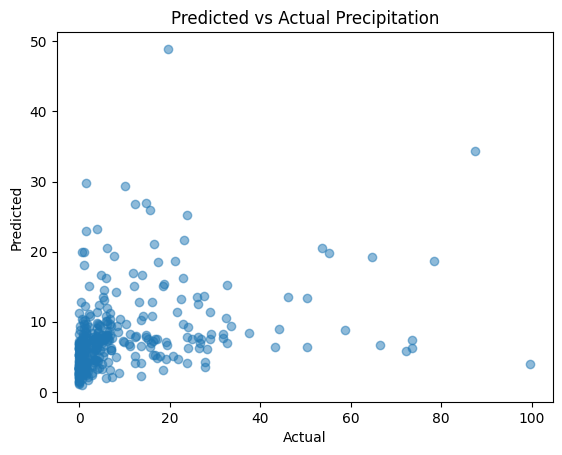

In [196]:
# Plot Scatter Plot Predicted vs Actual Precipitation
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Precipitation")
plt.show()

Residual Plot

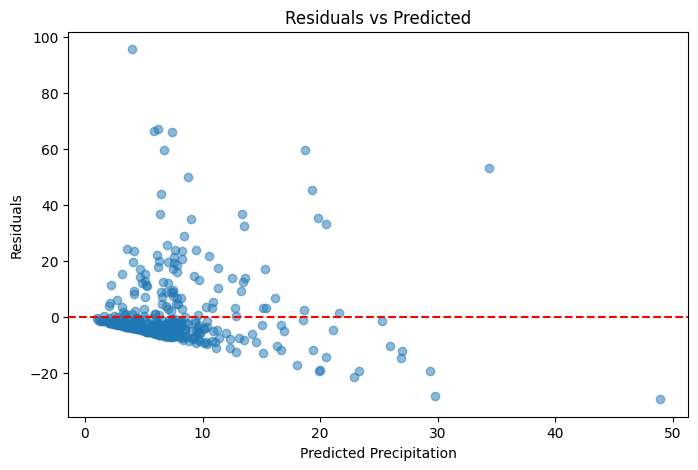

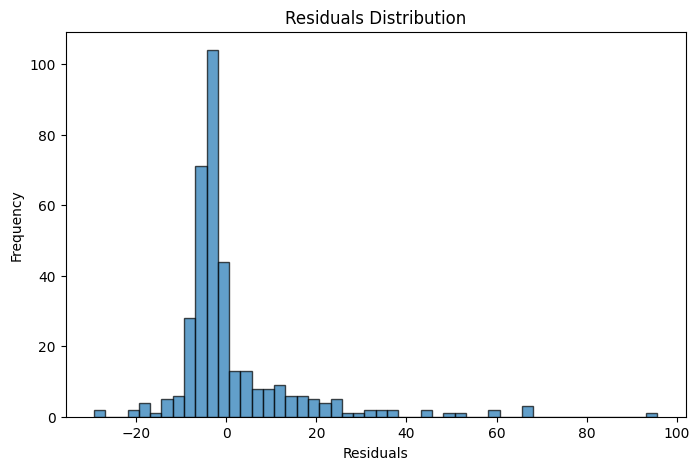

In [199]:
# converts single-column DataFrame to Series
y_test_series = y_test.squeeze() 

# Calculate residuals
residuals = y_test_series - y_pred

# Scatter plot of residuals vs predicted values
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Precipitation")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# Histogram of residuals
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

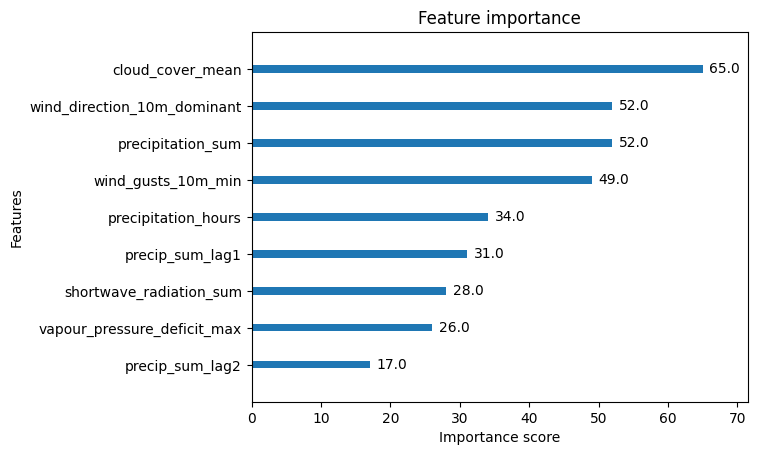

In [142]:
# Plot importances
ax = xgb.plot_importance(final_model)
ax.grid(False)
plt.show()

### Baseline Model Performance

In [147]:
# Compute mean of training target
train_mean = y_data.mean()

# Predict test set with this mean
y_pred_baseline = np.full_like(y_test, fill_value=train_mean, dtype=np.float64)

# Evaluate
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)


print("Baseline RMSE on test set:", baseline_rmse)
print("Baseline MAE on test set:", baseline_mae)
print("Baseline R^2 on test set:", baseline_r2)

Baseline RMSE on test set: 14.829742435731161
Baseline MAE on test set: 8.966953614260683
Baseline R^2 on test set: -0.012792691622234509


In [201]:
# <Student to fill this section>
model_performance_explanations = """
To evaluate the effectiveness of the final XGBoost model, its performance was compared against a simple baseline
model. The baseline yielded a test RMSE of 14.83, MAE of 8.97, and an R² of -0.01, indicating that it performed
no better than a naive predictor of the mean.

In contrast, the final XGBoost model achieved a lower RMSE of 13.98 and MAE of 8.18, alongside an improved R-squared
of 0.10. This demonstrates that the final model not only reduced average prediction errors compared to the baseline 
but also captured some meaningful variance in the target variable.

The scatter plot shows predictions clustered at low precipitation values, with wider dispersion at higher levels, 
indicating underprediction of extremes. The residual plot reveals heteroscedasticity, as errors increase with larger values. 
This suggests the model captures general trends but struggles with high-variance events such as heavy rainfall.

"""

In [202]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance


In [203]:
# <Student to fill this section>
business_impacts_explanations = """
The model provides forecasts of 3-day precipitation sums, supporting planning in weather-sensitive operations 
such as agriculture, logistics, and events. Accurate predictions reduce operational risk and improve resource allocation.

However, the model tends to underpredict extreme rainfall, so high-impact events could be missed, 
potentially causing operational disruptions, financial losses, or safety hazards. Overestimating precipitation 
may also lead to unnecessary costs.

Understanding these limitations is crucial for stakeholders to manage decisions and account for residual risks.
"""

In [204]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [205]:
# <Student to fill this section>
experiment_outcome = "Hypothesis Confirmed" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [206]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [209]:
# <Student to fill this section>
experiment_results_explanations = """
The hypothesis was confirmed, as the XGBoost model outperformed the baseline in terms of RMSE, MAE, and R-squared. 
This demonstrates that the model can capture meaningful patterns in the 3-day precipitation sums.

New insights include the identification of the strongest predictors and the model’s limitations in predicting 
extreme rainfall events. Given these results, further experimentation could focus on enhanced feature engineering, 
incorporating external data, or exploring alternative model architectures to improve high-variance predictions.

Since the model provides measurable improvement over the baseline, the next steps involve refining the model 
and preparing it for deployment into production, while ensuring stakeholders are aware of residual risks.
"""

In [210]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)